In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import os
import sys
from sklearn import preprocessing
from scipy import linalg as LA
from scipy import stats
from scipy.stats import chi2
from scipy import linalg
import scipy.special
from scipy.linalg import qr 
# sys.path.append('/Users/Nikolai/Dropbox/Projects/navi/Scripts')
# import navi as nv
style.use("ggplot")
np.seterr(invalid='ignore')
sns.set_style("white")
sns.set_context("paper")
sns.set_palette("deep")
%config InlineBackend.figure_format = 'retina'
import random

In [1]:
from sklearn import metrics
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from decimal import Decimal

### Functions

In [3]:
def cov_matrix(X):
    X=preprocessing.scale(X)
    return np.cov(X)

def wishart_matrix(X):
    dim=X.shape[1]
    X=preprocessing.scale(X)
    return np.dot(X,X.T)/(dim)

def get_eigen(Y):
    (L,V) = LA.eigh(Y)
    return (L,V)

def random_matrix(X):
    return np.apply_along_axis(np.random.permutation, 0, X)


def plot_mp(L,path=False):
    plt.figure()
    plot=sns.distplot(L,bins=60,norm_hist=True,kde=False,hist_kws={"alpha": 0.85,\
    "color":sns.xkcd_rgb["cornflower blue"]})
    plot.set(xlabel='Cell eigenvalues normalized distribution')
    x=np.linspace(0,3,1050)
    y=mp_pdf(x,L)
    plt.plot(x,y,sns.xkcd_rgb["pale red"],lw=2)
    plt.xlim([0,int(round(np.max(L)+0.5))])
    plt.grid()
    plt.legend(['Predicted MP distribution','Randomized data'], loc="upper right",frameon=True)
    if path:    
        plt.savefig(path)


def pre_plots(path=False):
    plt.figure()
    sns.distplot(df.unstack().values,bins=100, kde=False,hist_kws={"alpha": 1,\
    "color":sns.xkcd_rgb["coral pink"]})
    plt.gca().set_yscale("log")
    plt.yscale("log")
    plt.xlabel('log_2 (1+TPM)')
    if path:    
        plt.savefig(path+'TPM_Distribution_Single_Cell.pdf')
    
    plt.figure()
    np.fill_diagonal(Y,Y.mean())    
    sns.distplot(Y.flatten(),bins=100, kde=False,hist_kws={"alpha": 0.85,\
    "color":sns.xkcd_rgb["light orange"]})
    np.fill_diagonal(Yc,Yc.mean()) 
    sns.distplot(Yc.flatten(),bins=100, kde=False,hist_kws={"alpha": 1,\
    "color":sns.xkcd_rgb["dark lime green"]})
    plt.gca().set_yscale("log")
    plt.xlabel('Values in log_2 (1+TPM)')
    plt.legend(['Wishart matrix values, log_2 (1+TPM)','Covariance matrix values, log_2 (1+TPM)'],frameon=True)
    if path:    
        plt.savefig(path+'Covariance_wishart_Matrix_Single_Cell.pdf')
    
    plt.figure()
    sns.distplot(L[:],bins=600,kde=False,hist_kws={"alpha": 0.85,\
    "color":sns.xkcd_rgb["cornflower blue"]})
    plt.xlabel('Data Eigenvalue distribution')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlim(0,3)
    if path:    
        plt.savefig(path+'Eigenvalues_Single_Cell.pdf') 



def mp_calculation(L,Lr, eta=1, eps=10**-6, max_iter=1000):
    converged = False
    iter = 0
    loss_history = []
    b_plus=mp_parameters(Lr)['b_plus']
    b_minus=mp_parameters(Lr)['b_minus']
    L_updated=L[(L>b_minus) & (L<b_plus)]
    new_b_plus=mp_parameters(L_updated)['b_plus']
    new_b_minus=mp_parameters(L_updated)['b_minus']
    while not converged:
        loss=(1-float(new_b_plus)/float(b_plus))**2
        loss_history.append(loss)
        iter += 1 
        if loss <= eps:
            #print 'Converged, iterations:',iter
            converged = True
        elif iter == max_iter:
            print 'Max interactions exceeded!'
            converged = True
        else:
            gradient=new_b_plus-b_plus
            new_b_plus=b_plus+eta*gradient
            L_updated=L[(L>new_b_minus) & (L<new_b_plus)]
            b_plus=new_b_plus
            b_minus=new_b_minus
            new_b_plus=mp_parameters(L_updated)['b_plus']    
            new_b_minus=mp_parameters(L_updated)['b_minus']
    return L[(L>new_b_minus) & (L<new_b_plus)]


def mp_calculation_plot(L,Lr,L2,df,comparison=True,path=False,info=False,bins=800,bins2=30):
    
    if info:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        plt.figure()
    plot=sns.distplot(L[:],bins=bins,norm_hist=True,kde=False,hist_kws={"alpha": 0.85,\
                                                                       "color":sns.xkcd_rgb["cornflower blue"]})   
    
    plot.set(xlabel='First cell eigenvalues normalized distribution')
    x=np.linspace(0,int(round(np.max(L2)+0.5)),3000)
    y=mp_pdf(x,L2)
    #yr=mp_pdf(x,Lr)
    plt.plot(x,y,sns.xkcd_rgb["pale red"],lw=2)

    MP_data = mlines.Line2D([], [], color=sns.xkcd_rgb["pale red"],label='MP for random part in data'\
                            ,linewidth=2)
    MP_rand = mlines.Line2D([], [], color=sns.xkcd_rgb["sap green"],label='MP for randomized data' ,linewidth=1.5\
                            ,linestyle='--')
    randomized=mpatches.Patch(color=sns.xkcd_rgb["apple green"], label='Randomized data',alpha=0.75\
                              ,linewidth=3, fill=False)
    data_real=mpatches.Patch(color=sns.xkcd_rgb["cornflower blue"], label='Real data',alpha=0.85)
    
    if comparison:
        x=np.linspace(0,int(round(np.max(Lr)+0.5)),3000)
        yr=mp_pdf(x,Lr)
        sns.distplot(Lr[:],bins=bins2,norm_hist=True,kde=False,hist_kws={"histtype": "step","linewidth": 3,\
                                                                  "alpha": 0.75,"color":sns.xkcd_rgb["apple green"]})
        plt.plot(x,yr,sns.xkcd_rgb["sap green"],lw=1.5,ls='--')
        plt.legend(handles=[data_real, MP_data , randomized,MP_rand], loc="upper right",frameon=True)
    else: 
        plt.legend(handles=[data_real, MP_data], loc="upper right",frameon=True)
    
    plt.xlim([0,int(round(np.max(L2)+1.5))])
    plt.grid()
        
    if info:
        dic=mp_parameters(L2)
        info1 = r'$\bf{Data\ Parameters}$'+'\n%i cells\n%i genes'\
                                %(df.shape[0], df.shape[1])
        info2 = '\n'+r'$\bf{MP\ distribution\ in\ data}$'+'\n$\gamma=%.2f$\n$\sigma^2=%.2f$\n$b_-=%.2f$\n$b_+=%.2f$'\
                                %(dic['gamma'],dic['s'],dic['b_minus'], dic['b_plus'])
        info3='\n'+r'$\bf{Analysis}$'+'\n%i eigenvalues > $\lambda_c (3 \sigma)$\n%i noise eigenvalues'\
                                %(len(L[L>_tw(L,Lr)]),df.shape[0]- len(L[L>_tw(L,Lr)]) )
        ks=scipy.stats.kstest(L2,call_mp_cdf(L2))
        info4= '\n'+r'$\bf{Statistics}$'+'\nKS distance ={0}'.format(round(ks[0], 4))\
                                +'\nKS test p-value={0}'.format(round(ks[1], 2))
        
        infoT= info1+info2+info4+info3
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        at=AnchoredText(infoT,loc=2, prop=dict(size=10), frameon=True,bbox_to_anchor=(1., 1.024),\
                       bbox_transform=ax.transAxes)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        lgd=ax.add_artist(at)
    
        if path:    
            plt.savefig(path, bbox_extra_artists=(lgd,), bbox_inches='tight')
    else:
        if path:    
            plt.savefig(path)
    return plt.show()


def _tw(L,Lr):
    L2=mp_calculation(L,Lr)
    gamma=mp_parameters(L2)['gamma']
    p=len(L)/gamma
    sigma=1.0/np.power(p,2.0/3.0)*np.power(gamma,5.0/6.0)*np.power((1+np.sqrt(gamma)),4.0/3.0)
    lambda_c=np.mean(L2)*(1+np.sqrt(gamma))**2+3*sigma
    return lambda_c


def get_significant_eigen(df):    
    Y=wishart_matrix(df)
    (L,V)=get_eigen(Y)
    Xr=random_matrix(df.values)
    Yr=wishart_matrix(Xr)
    (Lr,Vr) = get_eigen(Yr)
    Lr=np.real(Lr)
    return (L[L>_tw(L,Lr)],V[:,L>_tw(L,Lr)])     

def get_significant_noise_eigen(df):    
    Y=wishart_matrix(df)
    (L,V)=get_eigen(Y)
    Xr=random_matrix(df.values)
    Yr=wishart_matrix(Xr)
    (Lr,Vr) = get_eigen(Yr)
    s=(L<_tw(L,Lr)) & (L>mp_parameters(Lr)['b_minus'])
    return (L[L>_tw(L,Lr)],V[:,L>_tw(L,Lr)],L[s],V[:,s])     

def get_noise_eigen(df):    
    Y=wishart_matrix(df)
    (L,V)=get_eigen(Y)
    Xr=random_matrix(df.values)
    Yr=wishart_matrix(Xr)
    (Lr,Vr) = get_eigen(Yr)
    Lr=np.real(Lr)
    s=(L<tw(L,Lr)) & (L>mp_parameters(Lr)['b_minus'])
    return (L[s],V[:,s]) 
     
def project_genes(df,V):
    return np.dot(df.values.T,V)

# def project_genes(df,V):
#     c=0
#     n_components=len(L)
#     for j in V[:,:].T:
#          c+=np.outer(j,j)
#     Xh=np.dot(c,df.values)
#     df_projected=pd.DataFrame(Xh)
#     df_projected.columns=df.columns
#     return df_projected

def get_gene_norm(df):
    return np.sqrt(np.square(df).sum(axis=0)/(df.shape[0]+0.0))

def mp_parameters(L):
    moment_1=np.mean(L)
    moment_2=np.mean(np.power(L, 2))
    gamma=moment_2/float(moment_1**2)-1
    s=moment_1
    sigma=moment_2
    b_plus=s*(1+np.sqrt(gamma))**2
    b_minus=s*(1-np.sqrt(gamma))**2
    x_peak=s*(1.0-gamma)**2.0/(1.0+gamma)
    dic={'moment_1':moment_1,'moment_2':moment_2,'gamma':gamma,'b_plus':b_plus,'b_minus':b_minus,'s':s,'peak': x_peak}
    return dic

def _marchenko_pastur(x,dic):
    #For distribution of eigenvalues
    pdf=np.sqrt((dic['b_plus']-x)*(x-dic['b_minus']))/float(2*dic['s']*np.pi*dic['gamma']*x)
    return pdf

def mp_pdf(x,L):
    vfunc=np.vectorize(_marchenko_pastur)
    y=vfunc(x,mp_parameters(L))
    return y

def mp_pdf_real(x,n,p,s):
    gamma_real=n/float(p)
    a=s*(1-np.sqrt(gamma_real))**2
    b=s*(1+np.sqrt(gamma_real))**2
    return np.sqrt((x-a)*(b-x))/(2*np.pi*x*gamma_real*s)

def to_tpm(df):
    df2=df.copy()
    df2=df2.T/(df2.T.sum()+0.0)*10**(6)
    return df2.T

def zscore_gene(df):
    #Transform the data in the form so the mean in every column is zero and standard deviation is 1 in every row
    df2=df.T.copy()
    df2=df2.T
    df2=(df2-df2.mean())/(df2.std(ddof=0)+0.0)
    return df2

def _rank(df):
    return np.linalg.matrix_rank(df)

def get_random_ort_vectors(k,n_cells):
    Q,_=qr(np.random.randn(n_cells,n_cells))
    return Q[:,:k]



In [4]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import host_subplot

def _fit_gamma(x):
    alpha, loc, beta=stats.gamma.fit(x,loc=0,scale=1)
    return (alpha, loc, beta)

def _gamma_pdf(x,(alpha,loc,beta)):
    y=scipy.stats.gamma(a=alpha, loc=loc, scale=beta).pdf(x)
    return y
def plot_statistics(dfc,df,Vr,path=False,fit=False,fdr_cut=0.001):
    (Ls,Vs,Ln,Vn)=get_significant_noise_eigen(df) #WARNING! Part of this function is already calculated
    k=len(Ls)
    
    #Vna=get_random_ort_vectors(k,df.shape[0])
    #Vna=get_random_ort_vectors(k,df.shape[0])
    Vna=Vr[:,:k]
    dfp=project_genes(df,Vs)
    dfa=project_genes(df,Vna)
    dfnl=project_genes(df,Vn[:,:k])
    dfnr=project_genes(df,Vn[:,-k:])

    s=np.square(dfp).sum(axis=1)
    sa=np.square(dfa).sum(axis=1)
    snl=np.square(dfnl).sum(axis=1)
    snr=np.square(dfnr).sum(axis=1)
    
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=[9, 4.4])
    ax = plt.subplot(gs[0, 0])
    ax0 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
        
    sns.distplot(sa,norm_hist=True,kde=False,bins=100,hist_kws={"alpha": 0.8,\
                                            "color":sns.xkcd_rgb["golden yellow"],"zorder":1},)
    sns.distplot(s,norm_hist=True,kde=False,bins=200,hist_kws={"alpha": 0.6,\
                                            "color":sns.xkcd_rgb["cerulean"],"zorder":3})
    sns.distplot(snl,norm_hist=True,kde=False,bins=100,hist_kws={"alpha": 0.55,\
                                            "color":sns.xkcd_rgb["leaf green"],"zorder":5})
    sns.distplot(snr,norm_hist=True,kde=False,bins=100,hist_kws={"alpha": 0.5,\
                                            "color":sns.xkcd_rgb["cerise"],"zorder":7})
    plt.xlim([0,np.max(snr)+200])
    plt.xlabel('Normalized sample variance')
    plt.ylabel('Sample variance probability distribution')

    hist_sa=mpatches.Patch(color=sns.xkcd_rgb["golden yellow"], label='{0} random vectors'.format(k)\
                           ,alpha=0.8)
    hist_s=mpatches.Patch(color=sns.xkcd_rgb["cerulean"], label='All {0} signal eigenvectors'.format(k)\
                           ,alpha=0.6)
    hist_snl=mpatches.Patch(color=sns.xkcd_rgb["leaf green"], label='Lowest {0} MP eigenvectors'.format(k)\
                           ,alpha=0.55)
    hist_snr=mpatches.Patch(color=sns.xkcd_rgb["cerise"], label='Largest {0} MP eigenvectors'.format(k)\
                           ,alpha=0.5)
    xgr=np.linspace(0,np.max(snr)+200,1000)
    
    if fit:        
        xgl=np.linspace(0,np.max(snl),1000)
        xk=np.linspace(0,np.max(sa),1000)
        xs=np.linspace(0,np.max(s)+0,1000)

        fits=_fit_gamma(s)
        fitl=_fit_gamma(snl)
        fitr=_fit_gamma(snr)
        ygl=_gamma_pdf(xgl,fitl)
        ygr=_gamma_pdf(xgr,fitr)
        ys=_gamma_pdf(xs,fits)
        y=chi2.pdf(xk,k)
        
        plt.ylim(0,max(y)+0.02)
        
        plt.plot(xk,y,zorder=2,color=sns.xkcd_rgb["adobe"],linestyle='--',linewidth=1.1)
        plt.plot(xgl,ygl,zorder=6,color=sns.xkcd_rgb["grassy green"],linestyle='-',linewidth=1.5)
        plt.plot(xgr,ygr,zorder=8,color=sns.xkcd_rgb["rose red"],linestyle='-',linewidth=1.5)
        plt.plot(xs,ys,zorder=4,color=sns.xkcd_rgb["blue blue"],linestyle='-',linewidth=1.5)
      
        line_gammal = mlines.Line2D([], [], color=sns.xkcd_rgb["grassy green"]\
                                    ,label=r'Gamma PDF: $\alpha =%.1f$, $\beta = %.1f$'%(fitl[0],1/fitl[2])\
                                    ,linewidth=1.5)
        line_gammar = mlines.Line2D([], [], color=sns.xkcd_rgb["rose red"] \
                                    ,label=r'Gamma PDF: $\alpha =%.1f$, $\beta = %.1f$'%(fitr[0],1/fitr[2])\
                                    ,linewidth=1.5)
        line_chi = mlines.Line2D([], [], color=sns.xkcd_rgb["adobe"],label='Chi-Squared Distribution'\
                                 ,linewidth=1.1,linestyle='--')
        line_gammas = mlines.Line2D([], [], color=sns.xkcd_rgb["blue blue"]\
                                    ,label=r'Gamma PDF: $\alpha =%.1f$, $\beta = %.2f$'%(fits[0],1/fits[2])\
                                    ,linewidth=1.5)
        plt.legend(handles=[hist_s,line_gammas,hist_snr,line_gammar,hist_snl,line_gammal,hist_sa,line_chi],\
                      title=r'$\bf{Gene\ projection\ samples}$', loc="upper right",frameon=True)
    else:
        plt.legend(handles=[hist_s,hist_snr,hist_snl,hist_sa],\
                           title=r'$\bf{Gene\ projection\ samples}$', loc="upper right",frameon=True)
        
    ax1 = plt.subplot2grid((1, 3), (0, 2))
    

    def fdr(x):
            area_noise=snr[snr>x].shape[0]
            area_signal=s[s>x].shape[0]
            fdr=area_noise/float(area_signal)        
            genes=s[s>x].tolist()                        
            return (fdr,len(genes))                
    
    y_fdr=np.vectorize(fdr)(xgr)
       
    host =ax1# host_subplot(111)
    par = ax1.twinx()

    host.set_ylabel("False Discovery Rate")
    par.set_ylabel("Number of genes")
    
    p1, = host.plot(xgr, y_fdr[0], label="False Discovery Rate",ls='--',lw=2,color=sns.xkcd_rgb["pumpkin orange"])
    p2, = par.plot(xgr, y_fdr[1], label="Number of genes",ls='-.',lw=1.5,color=sns.xkcd_rgb["violet blue"])

    host.yaxis.get_label().set_color(p1.get_color())
    par.yaxis.get_label().set_color(p2.get_color())

    line_fdr = mlines.Line2D([], [], color=sns.xkcd_rgb["pumpkin orange"],\
             label='Ratio signal vs \nlargest {0} MP\ndistributions'.format(k),linewidth=2,linestyle='--')
    line_genes = mlines.Line2D([], [], color=sns.xkcd_rgb["violet blue"],\
             label='Relevant genes',linewidth=1.5,linestyle='-.')
    ax1.legend(handles=[line_fdr,line_genes],loc="upper right",frameon=True)
    
    host.set_yscale("log")
    host.grid('on')
    host.set_xlabel('Normalized sample variance')
    host.set_ylim(min(y_fdr[0]),1.2)
    host.set_xlim(-2,max(xgr))
    
    
    plt.tight_layout()
    
    cont=0
#    for i,n in enumerate(y_fdr[0]):
#        if n<fdr_cut and cont==0:
#            cut= xgr[i]
#            cont=1
#            s_gen=pd.Series(s,index=df2.columns)
#            dfc[s_gen[s_gen>cut].index.tolist()]\
#            .to_csv('../{0}_denoised_by_selection.txt'.format(name),sep='\t')  
    
    if path:
        plt.savefig(path)
        
#    print min(y_fdr[0]),min(y_fdr[1])
    return plt.show()
    

In [5]:
def data_description(dfr,dfc,path=False):
    fig = plt.figure(figsize=[8, 7])
    plt.subplot(2,2,1)
    sns.distplot( (dfr.T>0).sum(),kde=False,bins=60,color=sns.xkcd_rgb["goldenrod"],hist_kws={"alpha": 0.8})
    sns.distplot( (dfc.T>0).sum(),kde=False,bins=60,hist_kws={"alpha": 0.9\
                 ,'linewidth':0.8, 'fill':False,'edgecolor':sns.xkcd_rgb["cerulean"]})
    plt.xlabel('Number of genes per cell')
    plt.legend(['Raw data','Clean data'], loc="upper right",frameon=True)


    plt.subplot(2,2,2)
    sns.distplot(np.log10(0+dfr.sum()),kde=False,bins=30,color=sns.xkcd_rgb["strawberry"],hist_kws={"alpha": 0.9})
    sns.distplot(np.log10(0+dfc.sum()),kde=False,bins=18,color=sns.xkcd_rgb["green yellow"],hist_kws={"alpha": 0.9})
    plt.xlabel('Number of transcripts per gene (log10 scale)')
    plt.legend(['Raw data','Clean data'], loc="upper right",frameon=True)


    plt.subplot(2,2,4)    
    sns.regplot((dfr.mean()),(dfr>0).sum()/dfr.shape[0],scatter=True,fit_reg=False, scatter_kws={'s':2\
                ,'color':sns.xkcd_rgb["bright blue"]})
    sns.regplot((dfc.mean()),(dfc>0).sum()/dfr.shape[0],scatter=True,fit_reg=False, scatter_kws={'s':2\
                ,'color':sns.xkcd_rgb["cherry red"]})
    plt.gca().set_xscale("log")
    plt.ylabel('Fraccion of cells expressing a gene')
    plt.xlabel('Average gene expression')
    plt.ylim(-0.05,1.05)
    plt.legend(['Raw data','Clean data'], loc="upper left",frameon=True)

        
    plt.subplot(2,2,3)
    sns.distplot(np.log10(1+ (dfr>0).sum()),kde=False,bins=25,color=sns.xkcd_rgb["lightblue"]\
                 ,hist_kws={"alpha": 0.9})
    sns.distplot(np.log10(1+ (dfc>0).sum()),kde=False,bins=17,color=sns.xkcd_rgb["light lavender"]\
                 ,hist_kws={"alpha": 0.9})
    plt.xlabel('Number of cells expressing a gene (log10 scale)')
    plt.legend(['Raw data','Clean data'], loc="upper right",frameon=True)

    
    if path:
        plt.savefig(path)
    return plt.show()

In [6]:
def heatmap(df,core=3):
    matrix_dist = metrics.pairwise.pairwise_distances(df.values, metric="correlation", n_jobs=core)
    fig=plt.figure()
    cax=plt.imshow(1-matrix_dist, cmap='hot', interpolation='nearest')
    cbar = fig.colorbar(cax)
    plt.show()
    return 1-matrix_dist

In [331]:
from scipy.special import erf
from scipy import stats
#from joblib import Parallel, delayed

def pdf_max_entropy(x,ex):
    return 1/np.sqrt(2*np.pi*np.var(ex))*np.exp(-(x-np.mean(ex))**2/float(2*np.var(ex)))

def cdf_max_entropy(x,ex):
    return 1/float(2)*(1+erf((x-np.mean(ex))/np.sqrt(2*np.var(ex))))#*(1/np.sqrt(2*np.pi*np.var(ex)))

def call_entropy_cdf(ex):
    func= lambda y: map(lambda x: cdf_max_entropy(x,ex), y)
    return func


def _worker(VV):
    ex=VV
    stat=scipy.stats.kstest(ex,call_entropy_cdf(ex))
    return stat[0],stat[1]

def KS_test_entropy(V,(m,n),jobs):
    dist=[]
    pval=[]           
    VT = V.T    
    for t in Parallel(n_jobs=jobs)(delayed(_worker)(VT[i]) for i in np.arange(m,n,1)):
        dist.append(t[0])
        pval.append(t[1])
    return (dist,pval)


def eign_entropy(V,eig,path=False):
    ex=pd.DataFrame(V.T[eig])[0]
    x = np.linspace(min(ex), max(ex), 120)
    
    fig, axs = plt.subplots(1,3,figsize=[15, 4.4])
    axs = axs.flat
    #fig = plt.figure(figsize=[15, 4.4])
    plt.subplot(1,3,2)
    sns.distplot(ex, kde=False,norm_hist=True,bins=20)
    y=pdf_max_entropy(x,ex)
    plt.plot(x,y)
    plt.legend(['Maximum entropy PDF','Eigenvector components'], loc="upper left",frameon=True, prop={'size': 6})
    plt.xlabel('Eigenvector components distribution')

    plt.subplot(1,3,3)
    plt.plot(x,call_entropy_cdf(ex)(x))
    plt.hist(ex, 30, normed=True,cumulative=True, histtype='step',alpha=1,color='red',lw=1.2)
    plt.xlim(min(ex), max(ex))
    plt.legend(['Maximum entropy CDF','Eigenvector CDF'], loc="upper left",frameon=True)
    axs[2].text(-0.1, 0.5, "hpla")

    plt.xlabel('Kolmogorov Smirnov test')
    
    plt.subplot(1,3,1)
    pp=(ex).reset_index();
    plt.plot(pp['index'].values,pp[0].values**2,lw=1)
    plt.xlabel('Eigenvector components')
    if path:
        plt.savefig(path)
    
    plt.show()
    
    return scipy.stats.kstest(ex,call_entropy_cdf(ex))

In [13]:
from scipy import stats
def my_func(x):  
    #stat=scipy.stats.kstest(x,call_entropy_cdf(x))
    return stats.shapiro(x)[0]
def my_func2(x):  
    #stat=scipy.stats.kstest(x,call_entropy_cdf(x))
    return stats.shapiro(x)[1]
def my_func3(x):  
    #stat=scipy.stats.kstest(x,call_entropy_cdf(x))
    return stats.normaltest(x)[0]


In [14]:
from sklearn import cluster, preprocessing, manifold
from sklearn.decomposition import PCA

def visualize(df,lib='All',type='mds', distance='', lib_name='Type', path='projection_plot.pdf',perplexity=30): 
    #Visualizes data using 2d MDS projections and PCA
    #lib annotates every row of the data 
    X = df.values
    X_std=X#StandardScaler().fit_transform(X)#First we normalize the data by Zscore
    if type=='mds':
        if distance=='precomputed':
            similarities=df.values
        else:
            similarities = 1-np.corrcoef(X_std)
   
        mds = manifold.MDS(n_components=2, max_iter=500, eps=1e-8,
                       dissimilarity="precomputed", n_jobs=1)
        pos = mds.fit(similarities).embedding_
        clf = PCA(n_components=2)
        pos = clf.fit_transform(pos)
        dfad=pd.DataFrame(dict(coor1=pos[:,0], coor2=pos[:,1], Type=lib))
        g=sns.lmplot('coor1', 'coor2', data=dfad, \
             hue='Type', scatter_kws={"s": 10}, fit_reg=False)
        if lib_name!='Type':
            g._legend.set_title(lib_name)
        g.set_axis_labels('MDS Projection, Coordinate 1', 'MDS Projection, Coordinate 2')
        g.savefig(path)

    elif type=='pca':
        sklearn_pca = PCA(n_components=2)
        pos = sklearn_pca.fit_transform(X_std)
        dfad=pd.DataFrame(dict(coor1=pos[:,0], coor2=pos[:,1], Type=lib))
        g=sns.lmplot('coor1', 'coor2', data=dfad, \
             hue='Type', scatter_kws={"s": 10}, fit_reg=False)
        if lib_name!='Type':
            g._legend.set_title(lib_name)
        g.set_axis_labels('PC1, {0}%'.format(np.round(sklearn_pca.explained_variance_ratio_[0]*100)),\
                          'PC2, {0}%'.format(np.round(sklearn_pca.explained_variance_ratio_[1]*100)))
        g.savefig(path)

    elif type=='tsne':
        #tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity)
        tsne = mTSNE(n_components=2, init='random', random_state=0, perplexity=perplexity)
        pos = tsne.fit_transform(X_std)
        dfad=pd.DataFrame(dict(coor1=pos[:,0], coor2=pos[:,1], Type=lib))
        g=sns.lmplot('coor1', 'coor2', data=dfad, \
             hue='Type', scatter_kws={"s": 10}, fit_reg=False)
        g.set_axis_labels('t-SNE Projection, Coordinate 1', 't-SNE Projection, Coordinate 2')
        plt.axis('off')
        if lib=='All':
            plt.legend('off')
        g.savefig(path)

    plt.show()



In [22]:
def cleaning(raw,df, min_trans_per_gene=15,listout=False):
    #low-expressed genes
    genesproj=np.dot(df.values.T,(abs(Vr))[:,:int(round(len(Vr)/2))]).T
    shapiro_stat_gen=np.apply_along_axis(my_func, 0, genesproj[:,:])
    dist_genes=pd.Series(1-shapiro_stat_gen,index=df.columns[:])
    loop=0
    k=0
    while(loop==0):
        dist_genes_thrs=dist_genes.quantile([0.75-k]).values[0]
        genes_low_exp=dist_genes[(dist_genes>dist_genes_thrs)].index.tolist()
        dfc=raw.drop(genes_low_exp,axis=1)
        if dfc.sum().min()>min_trans_per_gene:
            loop=100
        else:
            k+=0.01
            
    #very expressed gene outliers        
    genes_thrs=0.5#dfc.median().quantile([0.98]).values[0]
    #genes_outlier=dfc.median()[(dfc.median()>genes_thrs)].index.values.tolist()
    genes_outlier=dfc.mean()[(dfc.mean()>genes_thrs)].index.values.tolist()
    dfc=dfc.drop(genes_outlier,axis=1)
    

    
    #very expressed cells
    cells_thrs=raw.T.median().quantile([0.98]).values[0]
    cells_outlier=raw.T.median()[(raw.T.median()>cells_thrs)].index.values.tolist()
    dfc=dfc.drop(cells_outlier,axis=0)
    
#     #low-expressed cells
#     dfc=dfc.loc[(dfc.T>0).sum()>0]    
#     dfc=dfc.loc[:,dfc.sum()>0]       
#     df2=np.log2(1+to_tpm(dfc))
#     df2=zscore_gene(df2)
#     Yc=wishart_matrix(df2)
#     (Lc,Vc) = get_eigen(Yc)
    
#     eig_proj_in_gene_space=np.dot(df2.values.T,(Vc)[:,:])
#     shapiro_stat_eig_proj=np.apply_along_axis(my_func, 0, eig_proj_in_gene_space[:,:])
#     dist_cells=pd.Series(1-shapiro_stat_eig_proj[0:df2.shape[0]/2],index=df2.index[0:df2.shape[0]/2])
#     dist_cells_thrs=10.002
#     cells_low_exp=dist_cells[(dist_cells>dist_cells_thrs)].index.tolist()
#     dfc=dfc.drop(cells_low_exp,axis=0)
    
    #final
    dfc=dfc.loc[(dfc.T>0).sum()>0]    # filter out cells without any expression after cleaning
    dfc=dfc.loc[:,dfc.sum()>0]       # filter out genes without any expression after cleaning

    df2=np.log2(1+to_tpm(dfc))
    df2=zscore_gene(df2)
    
    #list of genes and cells eliminated
    if listout==True:
        pd.DataFrame(genes_low_exp)\
                .to_csv('../{0}_trimmed_genes_low_expression.txt'.format(name),sep=',', index=False, header=False)
        pd.DataFrame(genes_outlier)\
                .to_csv('../{0}_trimmed_genes_high_expression.txt'.format(name),sep=',', index=False, header=False)
#         pd.DataFrame(cells_low_exp+cells_outlier)\
#                 .to_csv('../{0}_trimmed_cells.txt'.format(name),sep=',', index=False, header=False)
   
    return (dfc,df2)

In [21]:
def plot_localization(V,Vr,Vc,Vrc,path=False):

    distrc=np.apply_along_axis(my_func, 0, Vrc)  
    distc=np.apply_along_axis(my_func, 0, Vc) 
    distr=np.apply_along_axis(my_func, 0, Vr)  
    dist=np.apply_along_axis(my_func, 0, V)
    
    fig = plt.figure(figsize=[15, 8])
    plt.subplot(2,1,1)
    plt.plot(1-dist[1:],ls='-',lw=0.7,color=sns.xkcd_rgb["dodger blue"])
    plt.plot(1-distc[1:],ls='-',lw=1.5,color=sns.xkcd_rgb["lipstick red"])
    plt.ylim([-0.05,1])
    #plt.xlim([-50,len(V)+50])
    plt.xlim([len(V)-350,len(V)+10])
    plt.grid()
    plt.ylabel('1-Shapiro-Wilk normality statistics')
    plt.xlabel('Ranked Eigenvectors')
    plt.legend(['Data','Clean Data'], loc="upper left",frameon=True)

    plt.subplot(2,1,2)
    plt.plot(1-distr[1:],ls='-',lw=1.0,color=sns.xkcd_rgb["frog green"])
    plt.plot(1-distrc[1:],ls='-',lw=1.5,color=sns.xkcd_rgb["fern green"])
    plt.ylabel('1-Shapiro-Wilk normality statistics')
    plt.xlabel('Ranked Eigenvectors')
    plt.xlim([-50,len(V)+50])
    plt.ylim([-0.015,max(1-distr[1:])+0.05])
    plt.grid()
    plt.legend(['Randomized Data','Clean Randomized Data'], loc="upper left",frameon=True)

    if path:
        plt.savefig(path)
    return plt.show()

In [20]:
def cdf_marchenko(x,dic):

    if x < dic['b_minus']: 
        return 0.0
    elif x>dic['b_minus'] and x<dic['b_plus']:
        
        return 1/float(2*dic['s']*np.pi*dic['gamma'])*float(np.sqrt((dic['b_plus']-x)*(x-dic['b_minus']))+\
    (dic['b_plus']+dic['b_minus'])/2*np.arcsin((2*x-dic['b_plus']-dic['b_minus'])/(dic['b_plus']-dic['b_minus']))-\
    np.sqrt(dic['b_plus']*dic['b_minus'])*np.arcsin(((dic['b_plus']+dic['b_minus'])*x -2*dic['b_plus']*dic['b_minus'])/\
                                                ((dic['b_plus']-dic['b_minus'])*x)) )+np.arcsin(1)/np.pi
    else:
        return 1.0
    
    
def call_mp_cdf(L):
    func= lambda y: map(lambda x: cdf_marchenko(x,mp_parameters(L)), y)
    return func


In [116]:
def run_tSNE(df,comp,met,learning_rate =1000,perplexity=30,early_exaggeration=12,pca=True):
    tsne = manifold.TSNE(n_components=2, init='pca', metric=met,
                         learning_rate =learning_rate,perplexity=perplexity,early_exaggeration=early_exaggeration)    
    if pca:
        pca = PCA(n_components=comp)
        df_pca = pca.fit_transform(df)
        df_tsne = tsne.fit_transform(df_pca)
    else:
        df_tsne = tsne.fit_transform(df)

    return pd.DataFrame(df_tsne, index=df.index)

from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_tSNE(tsne, path=False, title=False,palette=False,labels=False,gene=False,data=False
              ,size=False,legend=True,psize=False):
    if psize:
        psize=psize
    else:
        psize=5
    if size:
        size_pl=size
    else:
        size_pl=6
    if type(labels) is list:
        tsn=tsne.copy()
        tsn['label']=labels 
        tsn.columns=['t-SNE1','t-SNE2','label']

        if palette:
            pal=palette
            with sns.plotting_context("paper",font_scale=1.5):
                g = sns.lmplot(x='t-SNE1', y='t-SNE2', fit_reg=False, scatter_kws={'s':psize, 'alpha':.9}\
                   , hue='label', data=tsn, size=size_pl,palette=sns.set_palette(pal),legend=False)
            g.set(yticks=[],xticks=[])
        else:
            with sns.plotting_context("paper",font_scale=1.5):
                g = sns.lmplot(x='t-SNE1', y='t-SNE2', fit_reg=False, scatter_kws={'s':psize, 'alpha':.9}\
                , hue='label', data=tsn, size=size_pl,legend=False,palette=sns.color_palette("husl",int(len(set(labels)))+1))
            g.set(yticks=[],xticks=[])            
        if legend:    
            if title:    
                plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
                   ncol=5,frameon=True, markerscale=np.floor(size_pl/3.),fontsize=size_pl+1.0)
            else:
                plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0),
                    ncol=5,frameon=True, markerscale=np.floor(size_pl/3.),fontsize=size_pl+1.0)
       
    elif type(gene) is list:
        with plt.style.context('seaborn-paper'):
            plt.figure(figsize=(size_pl,size_pl+0.5))
            tsn=tsne.copy()
            if type(data) is not bool:
                dat=data
            else:
                dat=df            
            if gene[0]=='library':
                tsn.loc[dat.index,'gene']= (dat.T>0).sum()
            else:
                tsn.loc[dat.index,'gene']= dat[gene].T.mean()
            tsn.columns=['t-SNE1','t-SNE2','gene']
            g=plt.scatter(tsn.loc[:, 't-SNE1'], tsn.loc[:, 't-SNE2'], s=psize,
               c=tsn.loc[:, 'gene'], alpha=.9, cmap='coolwarm')
            plt.xlabel('t-SNE1')
            plt.ylabel('t-SNE2')
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.autoscale(enable=True, axis='both', tight=True)
            
            divider = make_axes_locatable(plt.gca())
            cax = divider.append_axes("right", "2.5%", pad="1%")
            if gene[0]=='library':
                plt.colorbar(g, cax=cax,label='library complexity')
            else:
                plt.colorbar(g, cax=cax,label='log2(1+TPM)')
 
    elif type(gene) is tuple:
            n=len(gene)
            nrow = int(np.sqrt(n))
            ncol = int(np.ceil(n / nrow))
            if (n % 2 != 0 and n>3) or nrow*ncol<n:
                ncol=ncol+1
            if n<4:
                fig, axs = plt.subplots(nrow, ncol, dpi=100, figsize=(ncol*size_pl*1.5, nrow*size_pl*1.5))
            else:
                fig, axs = plt.subplots(nrow, ncol, dpi=100, figsize=(ncol*size_pl, nrow*size_pl))
            if nrow*ncol>n:
                for i in range(0,int(ncol*nrow-n)):
                    fig.delaxes(axs[-1][-(i+1)])            
            if type(axs) != np.ndarray:
                axs = [axs]
            else:
                axs = axs.ravel()
            for i in range(n):
                if i < n:
                    if type(gene[i]) is list:
                        marker=gene[i]
                    else:
                        marker = [gene[i]]
                    with plt.style.context('seaborn-paper'):
                        tsn=tsne.copy()
                        if type(data) is not bool:
                            dat=data
                        else:
                            dat=df            
                        if marker[0]=='library':
                            tsn.loc[dat.index,'gene']= (dat.T>0).sum()
                        else:
                            tsn.loc[dat.index,'gene']= dat[marker].T.mean()
                                               
                        tsn.columns=['t-SNE1','t-SNE2','gene']
                        g=axs[i].scatter(tsn.loc[:, 't-SNE1'], tsn.loc[:, 't-SNE2'], s=psize,
                               c=tsn.loc[:, 'gene'], alpha=.9, cmap='coolwarm')
                        axs[i].set_xticks([])
                        axs[i].set_yticks([])
                        axs[i].autoscale(enable=True, axis='both', tight=True)
                        divider = make_axes_locatable(axs[i])
                        cax = divider.append_axes("right", "2.5%", pad="1%")
                        if marker[0]=='library':
                            fig.colorbar(g, cax=cax,label='library complexity')
                        else:
                            fig.colorbar(g, cax=cax,label='log2(1+TPM)')

                    if title:
                        axs[i].set_title(title)
                    else:
                        if len(marker)<2:
                            axs[i].set_title(str(marker[0]))
                        elif len(marker)>1:
                                axs[i].set_title('list starting with '+str(marker[0]))
                                
                    if i % ncol == 0:
                        axs[i].set_ylabel('t-SNE2')
                    if ((i // ncol) + 1) == nrow:
                        axs[i].set_xlabel('t-SNE1')

    else:
        tsn=tsne.copy()
        tsn.columns=['t-SNE1','t-SNE2']
        with sns.plotting_context("paper",font_scale=1.5):
            g = sns.lmplot(x='t-SNE1', y='t-SNE2', fit_reg=False, scatter_kws={'s':psize, 'alpha':.9, 'color':'black'}\
                   , hue=None, data=tsn, size=size_pl,aspect=1,legend=False)
        g.set(yticks=[],xticks=[])
                
    sns.despine(top=False, right=False, left=False, bottom=False)    
    plt.autoscale(enable=True, axis='both', tight=True)
    if title:
        plt.title(title)  
    if path:
        plt.savefig(path, bbox_inches='tight')        
    return plt.show()


In [190]:
def pca(comp,X,path=False):
    mypca = PCA(n_components=comp)
    df_pca=mypca.fit_transform(X)
    myvar=np.cumsum(np.round(mypca.explained_variance_ratio_, decimals=4)*100)
    myvar2=mypca.explained_variance_ratio_
    plt.plot(myvar2)
    plt.xlabel('number of components')
    #plt.xlim(0,20)
    plt.ylabel('cumulative explained variance')
    plt.show()
    if path:
        plt.savefig(path, bbox_inches='tight')
    return pd.DataFrame(df_pca,index=X.index)

In [15]:
from MulticoreTSNE import MulticoreTSNE as mTSNE

def run_tSNE_par(df,comp,met,learning_rate =1000,perplexity=30,early_exaggeration=12,pca=True,n_jobs=3):
    tsne =mTSNE(n_jobs=n_jobs, init='random', metric=met,
                learning_rate =learning_rate,perplexity=perplexity,early_exaggeration=early_exaggeration)
    if pca:
        pca = PCA(n_components=comp)
        df_pca = pca.fit_transform(df)
        df_tsne = tsne.fit_transform(df_pca)
    else:
        df_tsne = tsne.fit_transform(df)
    return pd.DataFrame(df_tsne,index=df.index)

In [16]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)


def detect_pick(v,scope,delta,kind):
    if kind=='max':
        pick=peakdet(v,delta, x = None)[0]
    elif kind=='min':
        pick=peakdet(v,delta, x = None)[1]
    list_max=[scope[int(i[0])] for i in pick]
    values_max=[i[1] for i in pick]
    return (list_max,values_max)

In [17]:
from collections import defaultdict

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

def hierarchical(pop,method='ward'):
    Y = scipy.cluster.hierarchy.linkage(pop.T, method=method)
    X = scipy.cluster.hierarchy.linkage(pop, method=method)
    return X,Y
    
def populations(pop,X,Y,thrs=None,ncolors=15,path=False,palette=False,cell_label=False):
    #thrs is te threshold in dendrogram
    #ncolors is number of colors in palette randomly generated
    # whatever you wanna color should be in the columns
    # cell_label if one wants to add extra info in columns colors
    
    if palette:
        palette_clust=palette
    else:
        palette_clust=[sns.xkcd_rgb[xkcol[i]] for i in random.sample(range(0, len(xkcol)), ncolors) ]

    Y = Y
    X = X

    if thrs is None:
        thrs = 0.5*max(Y[:,2])
    else:
        thrs=thrs
    scipy.cluster.hierarchy.set_link_color_palette(palette_clust)
    denC = scipy.cluster.hierarchy.dendrogram(Y,labels = pop.columns,color_threshold=thrs,no_plot=True)
    clustersC = get_cluster_classes(denC)
    clusterC = []
    for i in pop.columns:
        included=False
        for j in clustersC.keys():
            if i in clustersC[j]:
                clusterC.append(j)
                included=True
        if not included:
            clusterC.append(None)
    
    if cell_label:    
        gC = sns.clustermap(pop,
                linewidths=0, xticklabels=False, yticklabels=False, 
                cbar_kws={"orientation": "vertical"}, center=0, figsize=(7, 7)
                            ,col_colors=[clusterC,cell_label],col_linkage=Y,row_linkage=X)
    else:
        gC = sns.clustermap(pop,
            linewidths=0, xticklabels=False, yticklabels=False, 
            cbar_kws={"orientation": "vertical"}, center=0, figsize=(7, 7),col_colors=clusterC
                            ,col_linkage=Y,row_linkage=X )

        
    if path:
        plt.savefig(path, bbox_inches='tight')        
       
    tabC=pd.DataFrame()
    for i in set(denC['color_list']):  
        color_cluster=pd.Series(clusterC).apply(lambda x: x==str(i)).astype(int).values.tolist()
        tabC[i]=color_cluster
    if len(tabC.index)==len(pop.columns):
        tabC.index=pop.columns
        tabC=tabC[tabC.columns.intersection(palette_clust)]
        plt.show()
        return tabC
    else:
        print 'threshold too small'
        plt.show()

def plot_populations(tsne,popul,var,cluster=None,size=4,path=False, get_cluster=False):  
    if var is 'cell':
        if cluster is 'all':
            for i in range(0,popul.shape[1]):
                popul.T.iloc[i]=popul.T.iloc[i]*(i+1)
            if path:
                plot_tSNE(tsne,labels=popul.T.sum().tolist(),palette=popul.columns.tolist(),size=4,legend=False,path=path)
            else:
                plot_tSNE(tsne,labels=popul.T.sum().tolist(),palette=popul.columns.tolist(),size=4,legend=False)
            if get_cluster:
                return pd.DataFrame(popul.T.sum(),index=popul.index)
        elif type(cluster) is int:
            if path:
                plot_tSNE(tsne,labels=popul.T.iloc[cluster-1].tolist(),size=4,palette=['#cbf85f','#fa2a55'],legend=False,path=path)
            else:
                plot_tSNE(tsne,labels=popul.T.iloc[cluster-1].tolist(),size=4,palette=['#cbf85f','#fa2a55'],legend=False)
            if get_cluster:
                return popul.loc[popul.T.iloc[cluster-1]>0].index.tolist()
    elif var is 'gene':    
        if cluster is 'all':
            if path:
                plot_tSNE(tsne,gene=tuple([popul[i][popul[i]!=0].index.tolist() for i in popul.columns.tolist()]),path=path)
            else:
                plot_tSNE(tsne,gene=tuple([popul[i][popul[i]!=0].index.tolist() for i in popul.columns.tolist()]))
        elif type(cluster) is int:
            if path:
                plot_tSNE(tsne,gene=popul.T.iloc[cluster-1][popul.T.iloc[cluster-1]!=0].index.tolist(),size=4,path=path)
            else:
                plot_tSNE(tsne,gene=popul.T.iloc[cluster-1][popul.T.iloc[cluster-1]!=0].index.tolist(),size=4)
            if get_cluster:
                return popul.T.iloc[cluster-1][popul.T.iloc[cluster-1]!=0].index.tolist()
        else:
            if path:
                plot_tSNE(tsne,gene=tuple([popul.T.iloc[i-1][popul.T.iloc[i-1]!=0].index.tolist() for i in cluster]),size=size,path=path)
            else:
                plot_tSNE(tsne,gene=tuple([popul.T.iloc[i-1][popul.T.iloc[i-1]!=0].index.tolist() for i in cluster]),size=size)
    else:
        print 'The only valid variable (var) is gene or cell'


In [18]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

def plot_clusters(algorithm,comp,tsne,pop,size,legend=True,get_cluster=False,path=None):
    #KMeans : kmeans
    #SpectralClustering: spectral
    #Gaussian mixture models: gaussian
    
    if algorithm == 'kmeans':
        labl = KMeans(n_clusters=comp)
        labl.fit(pop)
        y_labl = labl.predict(pop)
    elif algorithm == 'spectral':
        labl = SpectralClustering(n_clusters=comp)
        labl.fit(pop)
        y_labl = labl.labels_
    elif algorithm == 'gaussian':
        labl = GaussianMixture(n_components=comp, init_params='kmeans')
        labl.fit(pop)
        y_labl = labl.predict(pop)

    else:
        print 'use kmeans, spectral or gaussian'

    if path:
        plot_tSNE(tsne,labels=y_labl.tolist(),size=size,legend=legend,path=path)
    else:
        plot_tSNE(tsne,labels=y_labl.tolist(),size=size,legend=legend)

    if get_cluster:
        return pd.DataFrame(y_labl.tolist(),index=tsne.index)


In [19]:
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

def _compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

def kmeans_bic_elbow(pop,comp):
    ks = range(1,comp)
    kk = [KMeans(n_clusters = i, init="k-means++").fit(pop.as_matrix()) for i in ks]
    BIC = [-1*_compute_bic(kmeansi,pop.as_matrix()) for kmeansi in kk]
    plt.scatter(ks,BIC)
    plt.show()
    elbow=[kmeansi.inertia_ for kmeansi in kk]
    plt.scatter(ks,elbow)
    plt.show()


    
def gaussian_bic_aic(pop,comp):
    n_components = np.arange(1, comp)
    models = [GaussianMixture(n, init_params='kmeans').fit(pop)
          for n in n_components]

    plt.plot(n_components, [m.bic(pop) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(pop) for m in models], label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components');
    plt.show()

In [20]:
#Palettes:
pallete_20=['#eecffe', '#056eee', '#ca6641', '#49759c', '#373e02', '#f4d054', '#b1d27b', '#78d1b6', '#c04e01',
 '#fffd37', '#ff69af', '#ff796c', '#4f9153', '#f9bc08', '#8d8468', '#947706', '#fdb0c0',
 '#c87f89', '#ff5b00', '#601ef9']

pallete_20II=['#b17261', '#e4cbff', '#cbf85f', '#005249', '#56ae57', '#f2ab15', '#0485d1', '#63b365', '#886806', '#1f6357',
 '#ae7181', '#6140ef', '#fdff52', '#c2ff89', '#014600', '#afa88b', '#650021', '#feb209', '#0504aa', '#3c4d03']

pallete_20III=['#ff5b00', '#056eee', '#601ef9', '#49759c', '#373e02', '#f4d054', '#b1d27b', '#78d1b6', '#c04e01',
              '#b17261', '#e4cbff', '#cbf85f', '#005249', '#56ae57', '#f2ab15', '#fdb0c0', '#650021', '#0504aa'
               , '#3c4d03']

##### Single cell loading, normalization and preprocess

In [16]:
%%time
#raw=pd.read_table('../Data/atac-seq.txt',index_col=0).T
raw=pd.read_table('../Data/Interferon/SS008_virus_clean.txt',index_col=0).T
#raw=pd.read_table('../../multimessenger _RNA/DATA_intrans.txt',index_col=0).T
#raw=pd.read_table('../Data/motor_neurons_clean.txt',index_col=0).T
#raw=pd.read_table('../Data/nuq-seq.txt',index_col=0).T
#raw=pd.read_table('../../prostate_project/Columbia_MM131415/MM013_clean.txt',index_col=0).T
#raw=pd.read_table('../Data/motor_neurons_per_day/motor_day6.txt',index_col=0,header=None).T

#raw=pd.read_table('../Data/GBM_PJ030-1.txt',index_col=0,header=None).T
#raw=pd.read_table('../Data/motor_neurons_nobatch.txt',index_col=0,header=None).T
#raw=pd.read_table('../Data/pbmc4k.txt',index_col=0)
#raw=pd.read_table('../../Virus_Preppi/Data/viral_protein_human_protein.matrix',index_col=0).T
#raw=pd.read_table('../../Virus_Preppi/Data/Protein_function/capsid_clean_tda.txt',index_col=0)
#raw=pd.read_table('../Data/Liver2_rm.batch_dge.txt',index_col=0,sep=' ').T
#raw=pd.read_table('../Data/embrio.txt',index_col=0)
#raw=pd.read_table('../Data/human_embrio.csv',index_col=0,sep=',').T
#raw=pd.read_table('../Data/68k_shortened.txt',index_col=0)


#raw=pd.read_table('../Data/mouse_cortex.txt',index_col=0,sep='\t')
#raw=pd.read_table('../Data/pbmc_Kang_et_al/pbmc_ctrl_annotated.txt',index_col=0,sep='\t')
#raw=pd.read_table('../Data/pancreas_annotated.txt',index_col=0,sep='\t')
#raw=pd.read_table('../Data/pbmc_seurat_clean.txt',index_col=0,sep='\t')
#raw=pd.read_table('../../../Downloads/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv',index_col=0,sep=',')


#raw=pd.read_table('../Data/prostate/MM033_human_clean.txt',index_col=0,sep='\t').T3
#name='prostate_human'

#name='pbmc_seurat'
#name='pancreas'
#name='pbmc_Kang'
#name='mouse_cortex'
#name='mouse_embrio'
#name='human_embrio'

#name='mouse_liver'
#name='Sagi_Virus_capside'
#name='pbmc_60k_shrt'
#name='nuq-seq'
name='Sagi_Interferon_SS008'
#name='motor_neurons_day6'
#name='GBM_PJ030-1'
#name='prostate_M013'
#name='atac-seq'

CPU times: user 3.24 s, sys: 425 ms, total: 3.67 s
Wall time: 4.2 s


In [17]:
#raw=pd.read_table('/Users/la2666/Downloads/AL_samples/AL001.txt',index_col=0,sep='\t')
#name='adolfo1'

In [249]:
name='pancreas_2'
raw=raw[raw.index.str.match('human2')]

In [250]:
raw.shape

(1714, 17488)

In [251]:
raw=raw.loc[(raw.T>0).sum()>0]    # filter out cells without any expression
raw=raw.loc[:,raw.sum()>0]        # filter out genes without any expression


dict_genes=dict(enumerate(raw.columns.values.tolist()))   # dictionary of genes names 
raw.columns=range(raw.shape[1])                           # genes by number
#raw.index=range(raw.shape[0])                             # cells by number

In [252]:
sortgenes=raw.mean().sort_values()     
raw=raw[sortgenes.index.tolist()]     # sort genes by expression in transcripts

sortcells=(raw.T>0).sum().sort_values()
raw=raw.loc[sortcells.index.tolist()]          # sort cells by average expression in transcripts

In [253]:
raw.columns=raw.columns.map(lambda x: dict_genes[x])

In [254]:
raw.shape

(1714, 16290)

In [17]:
df=to_tpm(raw)
df=np.log2(1+df)
df=zscore_gene(df)

In [18]:
%%time
Y=wishart_matrix(df)
(L,V)=get_eigen(Y)
Yrm=random_matrix(df)
Yr=wishart_matrix(Yrm)
(Lr,Vr)=get_eigen(Yr)

CPU times: user 6.18 s, sys: 376 ms, total: 6.56 s
Wall time: 3.8 s


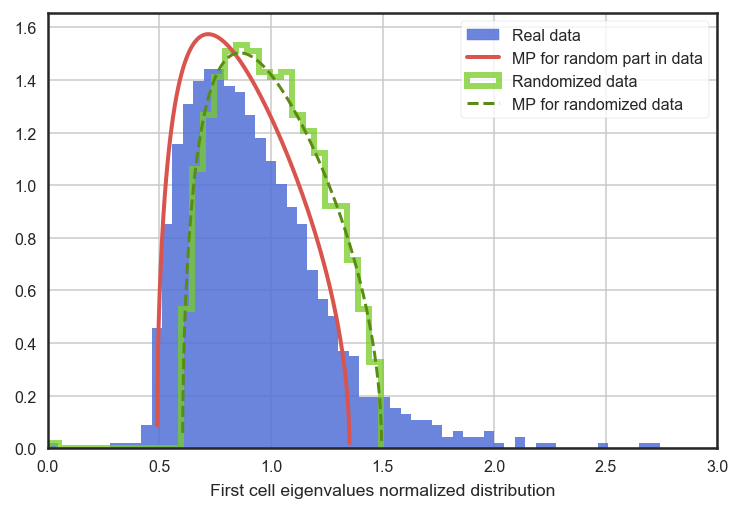

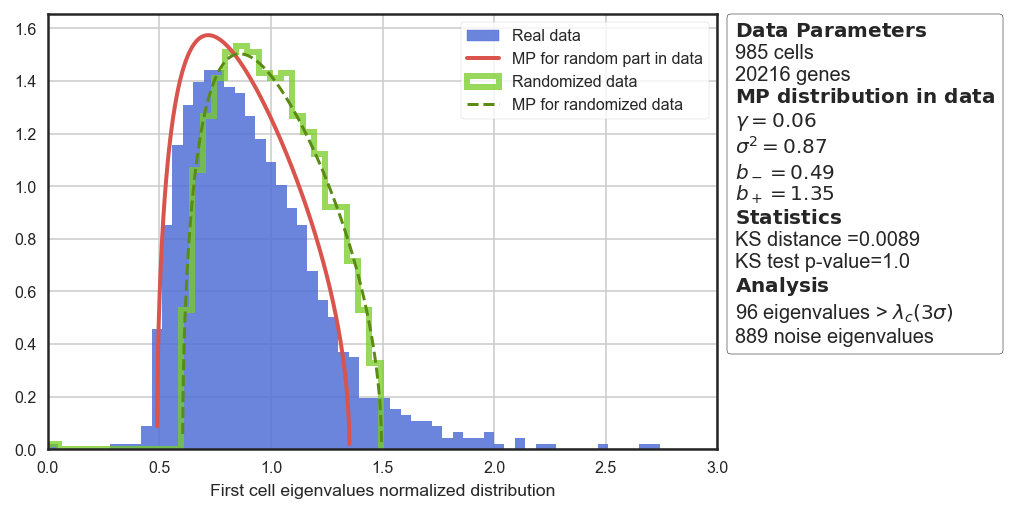

In [23]:
L2=mp_calculation(L,Lr)
mp_calculation_plot(L,Lr,L2,df,comparison=True,info=True,path='../{0}_MP_noclean.pdf'.format(name))

#### Localization phase transition

In [24]:
%%time
(dfc,df2)=cleaning(raw,df,10,listout=False)

CPU times: user 8.23 s, sys: 1.99 s, total: 10.2 s
Wall time: 9.54 s


In [25]:
dfc.shape

(983, 97)

In [318]:
Yc=wishart_matrix(df2)
(Lc,Vc) = get_eigen(Yc)
#Yrmc=random_matrix(df2)
#Yrc=wishart_matrix(Yrmc)
#(Lrc,Vrc)=get_eigen(Yrc)

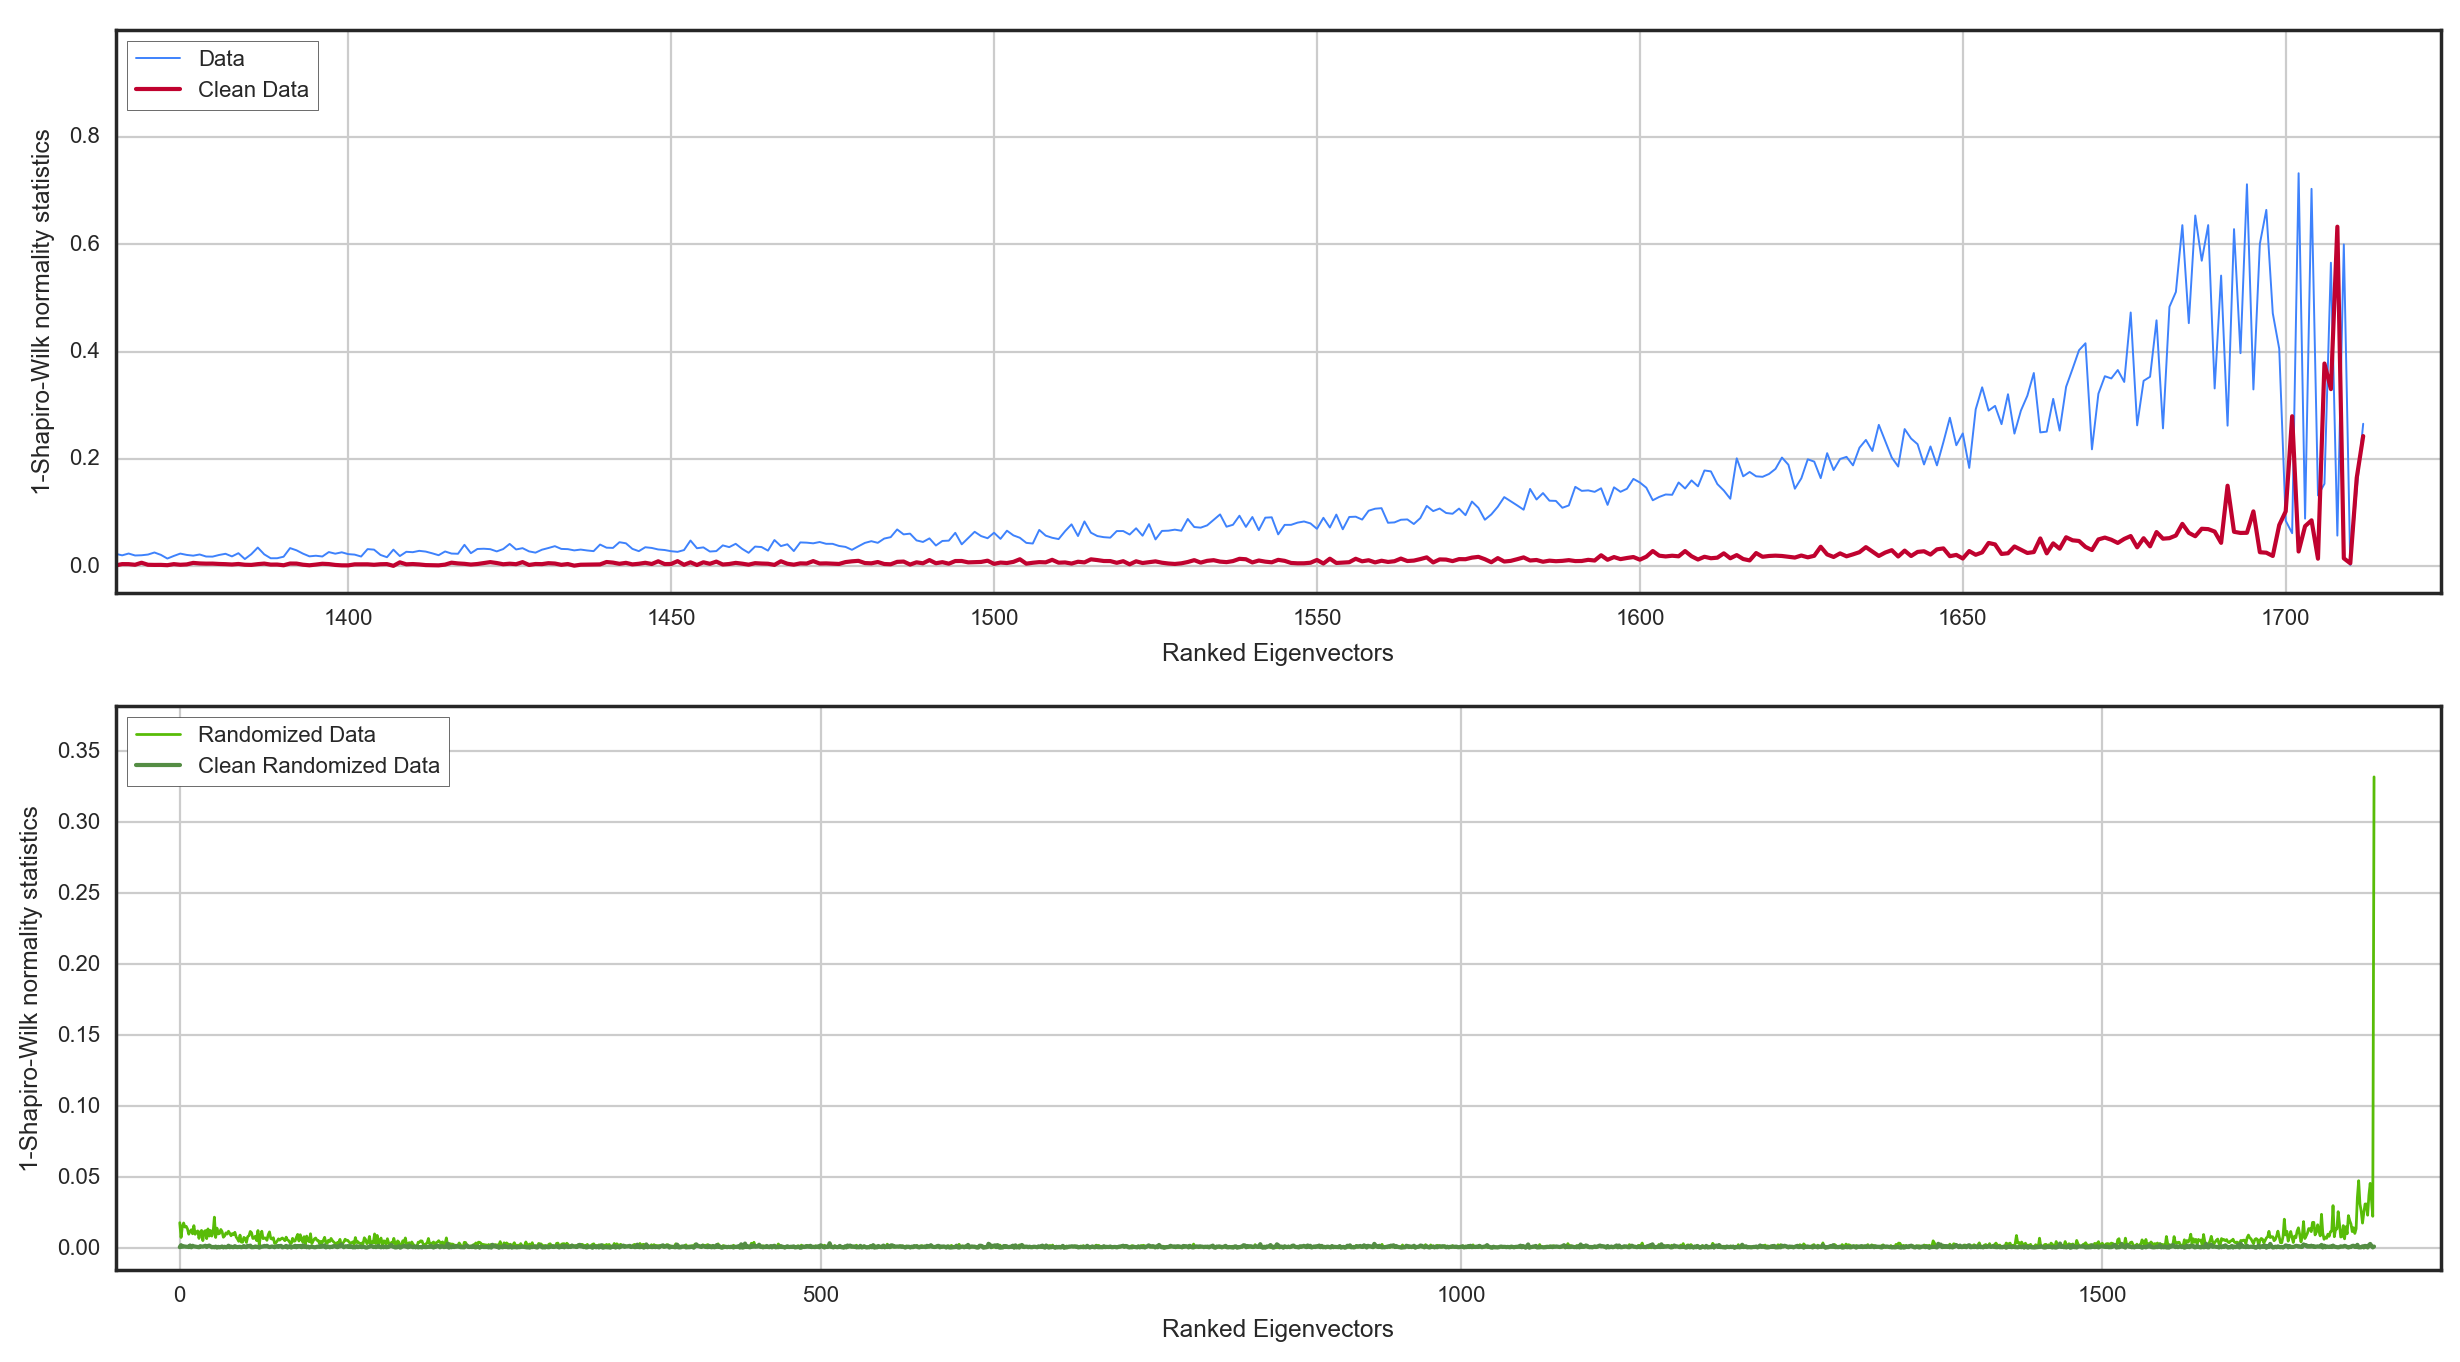

In [319]:
plot_localization(V,Vr,Vc,Vrc)#,path='../New_figures/{0}_localization.pdf'.format(name))

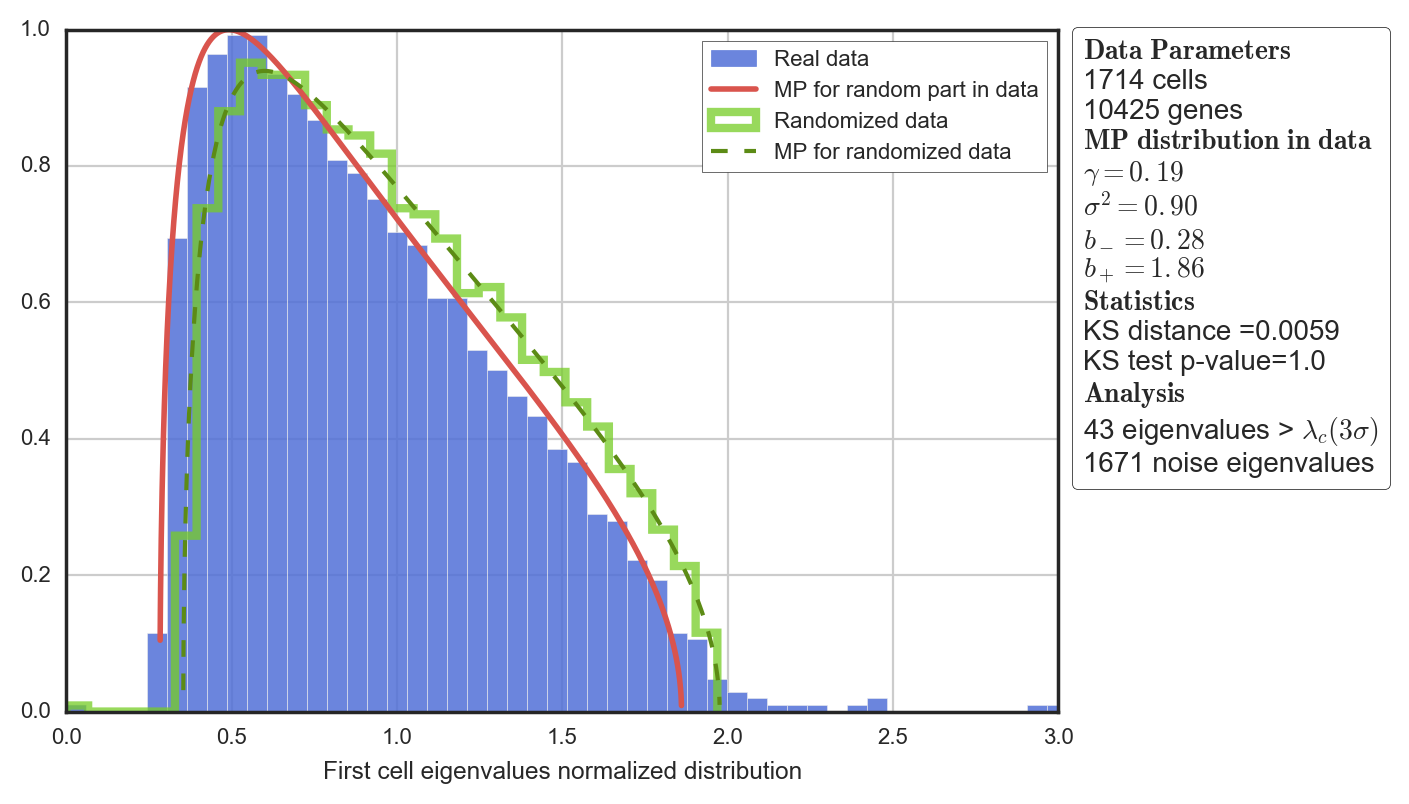

In [309]:
L2c=mp_calculation(Lc,Lrc)
mp_calculation_plot(Lc,Lrc,L2c,df2,comparison=True,info=True)#,bins=5200,bins2=60)
#                    path='../New_figures/{0}_MP_clean.pdf'.format(name))

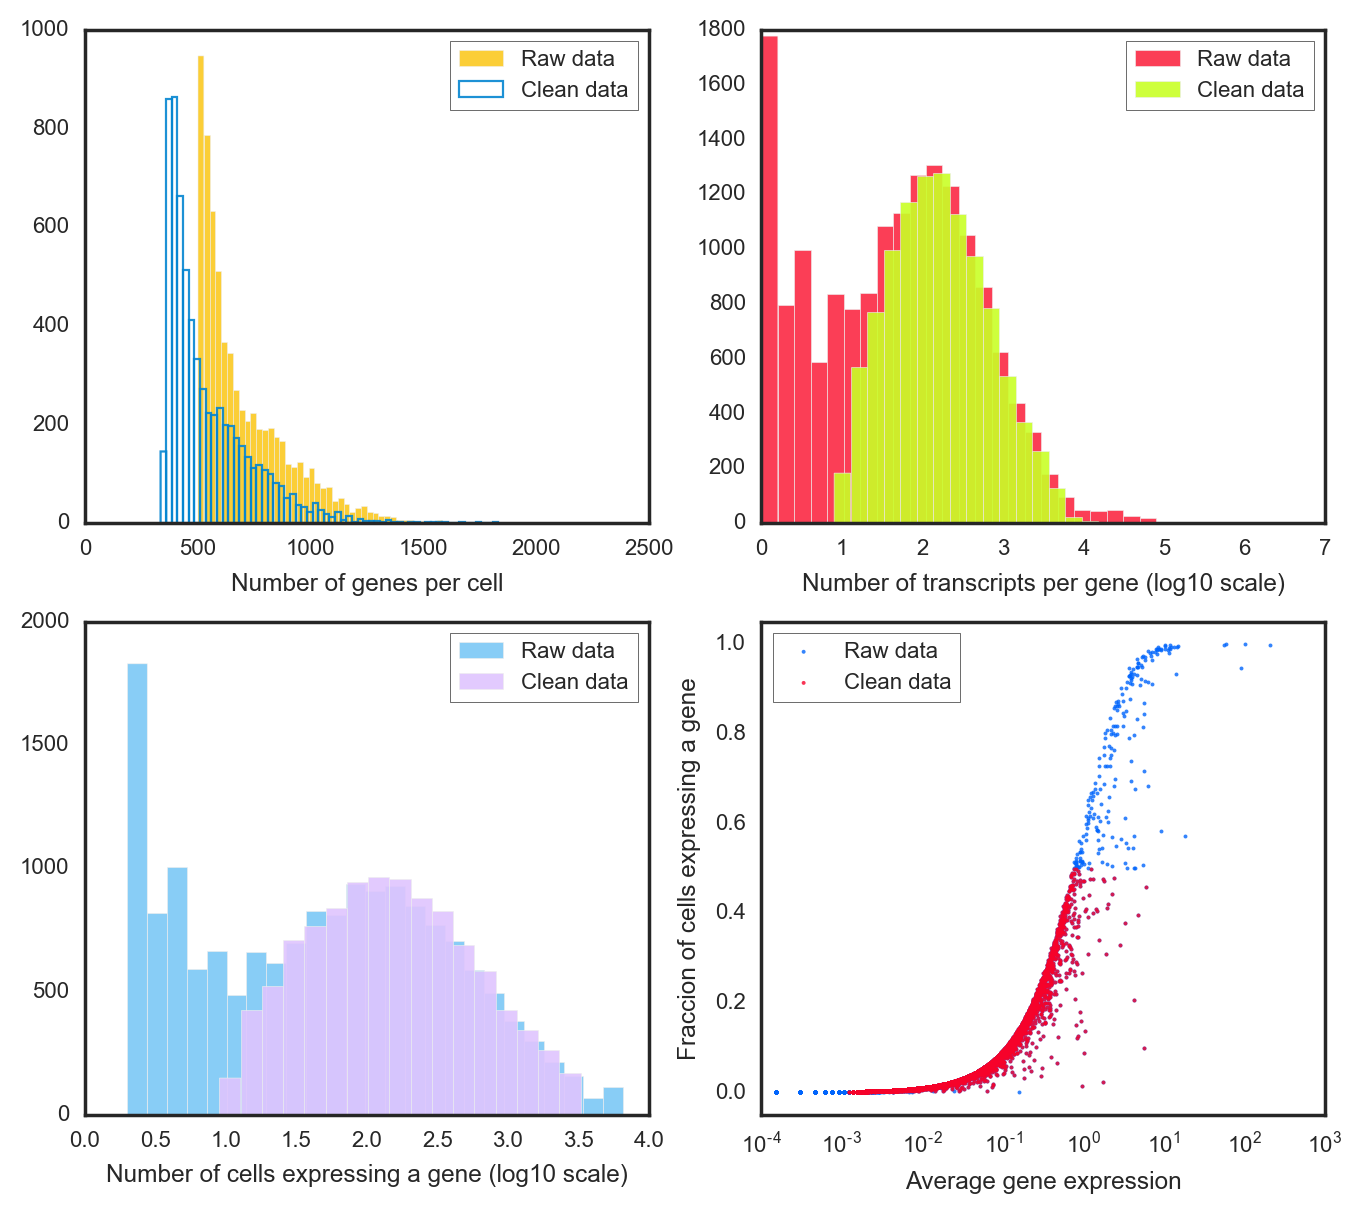

(6573, 10453)


In [1154]:
data_description(raw,dfc,path='../New_figures/{0}_data_statistics.pdf'.format(name))
print dfc.shape

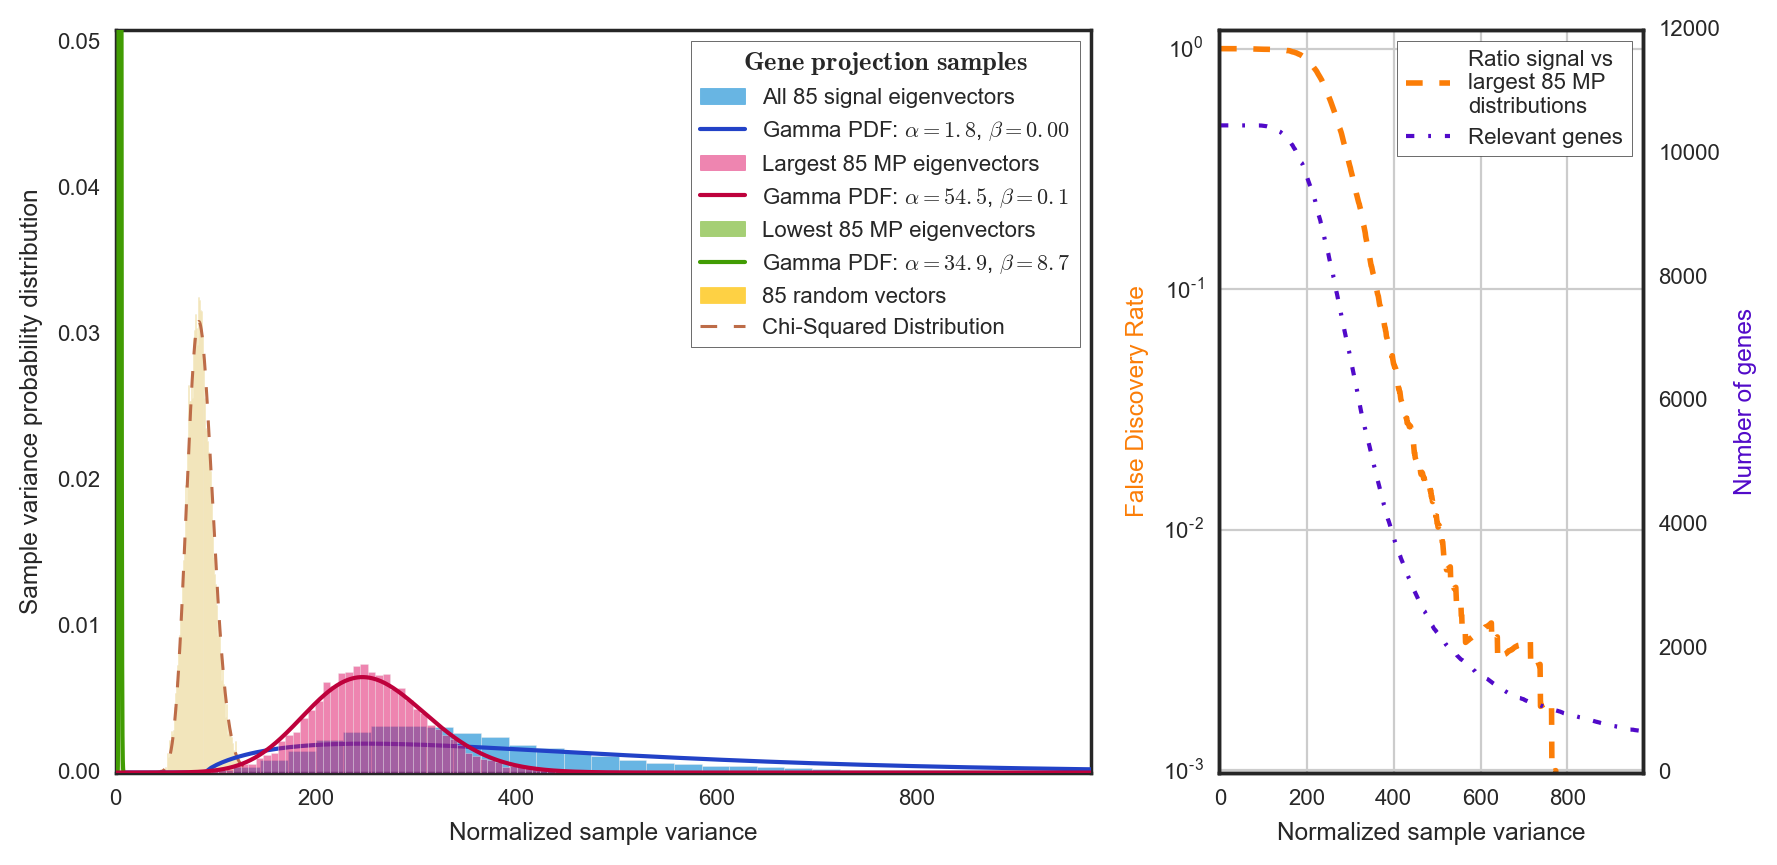

CPU times: user 4min 29s, sys: 9.2 s, total: 4min 38s
Wall time: 2min 4s


In [326]:
%%time
plot_statistics(dfc,df2,Vrc,fit=True)
                #,path='../New_figures/{0}_Parametric_Statistics.pdf'.format(name),fdr_cut=0.0001)

In [35]:
#df3=pd.read_table('../{0}_denoised_by_selection.txt'.format(name),sep='\t',index_col=0)
#df35=df3[df3.var().sort_values()[-4000:].index]
#df32=np.log2(1+to_tpm(df3))

In [327]:
%%time
#df2=np.log2(1+to_tpm(dfc))
#df2=zscore_gene(df2)
(U, S, V) = linalg.svd(df2, full_matrices=False)

#(U, S, V) = linalg.svd(np.log2(1+to_tpm(dfc)), full_matrices=False)

S[np.square(S)/df2.shape[1]<_tw(L2c,Lrc)]=0
df4=pd.DataFrame(np.dot(np.dot(U,np.diag(S)),V))
df4.columns=df2.columns
df4.index=df2.index
#df4.to_csv('../{0}_denoised.txt'.format(name),sep='\t')

CPU times: user 8min 23s, sys: 4.73 s, total: 8min 28s
Wall time: 2min 5s


In [59]:
#df4.to_csv('../../{0}_denoised.txt'.format(name),sep='\t')

###  t-SNEs

In [329]:
(Ls,Vs,Ln,Vn)=get_significant_noise_eigen(df2)
dfp=project_genes(df2,Vs)
s=np.square(dfp).sum(axis=1)
s_gen=pd.Series(s,index=df2.columns)

In [371]:
s1=set(s_gen[s_gen>800].index)
# s2=set(raw.var().sort_values(ascending=False)[0:700].index.tolist())
# s3=s1.intersection(s2)
print len(s1)

947


In [298]:
ello=[]
scope=range(0,int(round(max(s))),20)
for i in scope:
    esso=dfc[s_gen[s_gen>i].index.tolist()]
    ello.append((esso.var()/esso.mean()).mean()) #var().mean()

In [299]:
ello2=[]
scope=range(0,int(round(max(s))),20)
for i in scope:
    esso=df4[s_gen[s_gen>i].index.tolist()].T
    ello2.append((esso.var()/esso.mean()).mean())

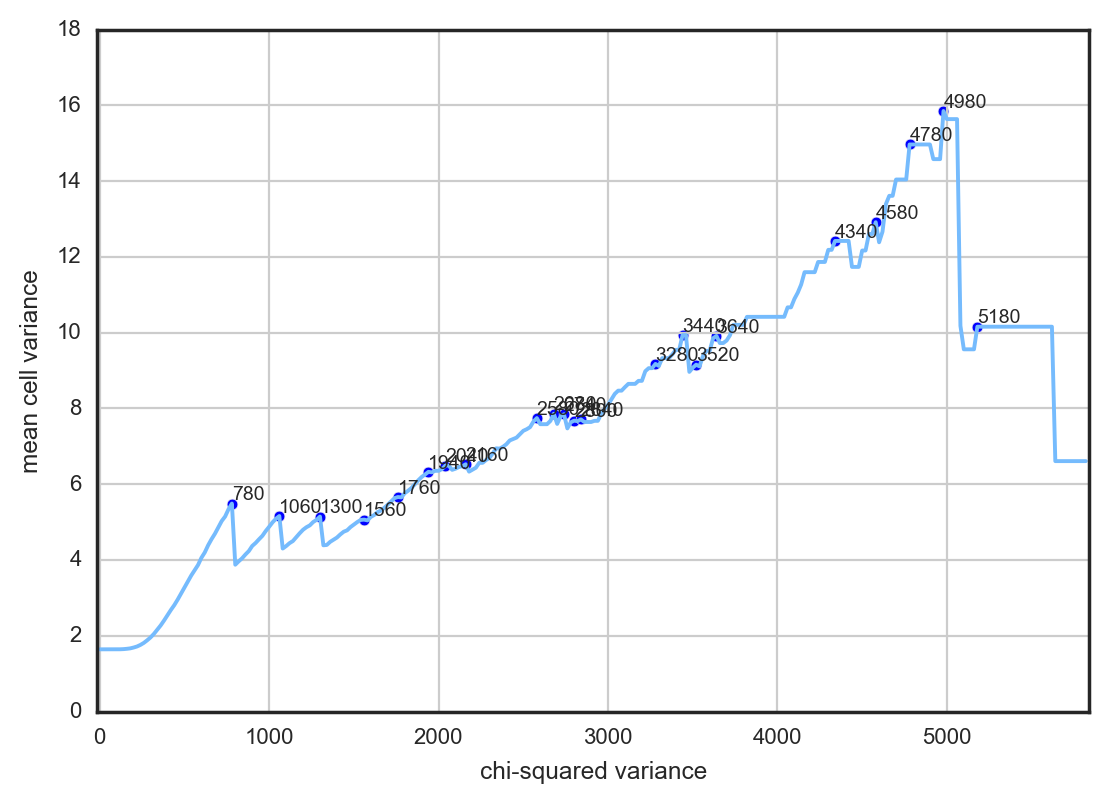

In [300]:
vval=ello
maxs=detect_pick(vval,scope,0.01,'max')
plt.xlabel('chi-squared variance')
plt.ylabel('mean cell variance')
plt.scatter(maxs[0],maxs[1],s=15,zorder=0)
plt.plot(scope,vval,zorder=1,color=sns.xkcd_rgb["sky blue"])
plt.grid()
#plt.ylim(0,max(vval)+20)
plt.xlim(-15,max(scope)+20)
for i in range(0,len(maxs[0])):
    plt.text(maxs[0][i], maxs[1][i]+0.1, maxs[0][i], fontsize=7)
#plt.savefig('../{0}_cell_var.pdf'.format(name))
plt.show()

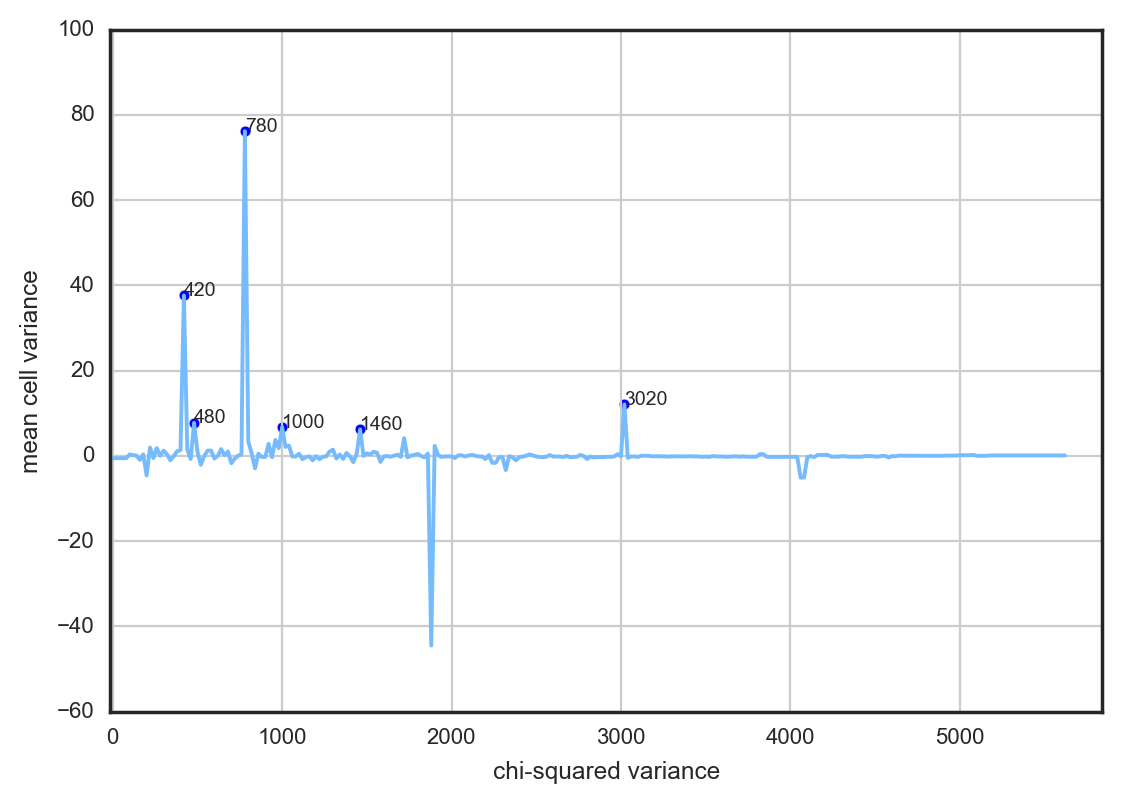

In [301]:
vval=ello2
maxs=detect_pick(vval,scope,6,'max')
plt.xlabel('chi-squared variance')
plt.ylabel('mean cell variance')
plt.scatter(maxs[0],maxs[1],s=15,zorder=0)
plt.plot(scope,vval,zorder=1,color=sns.xkcd_rgb["sky blue"])
plt.grid()
#plt.ylim(0,max(vval)+20)
plt.xlim(-15,max(scope)+20)
for i in range(0,len(maxs[0])):
    plt.text(maxs[0][i], maxs[1][i]+0.003, maxs[0][i], fontsize=7)
#plt.savefig('../{0}_cell_var_nul.pdf'.format(name))
plt.show()

In [66]:
tsne_max=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>1160].index.tolist()]).dropna()),83,'correlation')
tsne_max2=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>2400].index.tolist()]).dropna()),83,'correlation')
tsne_max3=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>3440].index.tolist()]).dropna()),50,'correlation')

In [331]:
tsne_max_ns=run_tSNE_par(df4[s_gen[s_gen>500].index.tolist()],78,'correlation',pca=True)
tsne_max_ns2=run_tSNE_par(df4[s_gen[s_gen>500].index.tolist()],78,'euclidean',pca=False)
tsne_max_ns3=run_tSNE_par(df4[s_gen[s_gen>800].index.tolist()],78,'euclidean',pca=True)

In [332]:
tsne_max_ns4=run_tSNE_par(df4[s_gen[s_gen>1000].index.tolist()],78,'euclidean',pca=True)
tsne_max_ns5=run_tSNE_par(df4[s_gen[s_gen>1500].index.tolist()],78,'euclidean',pca=True)

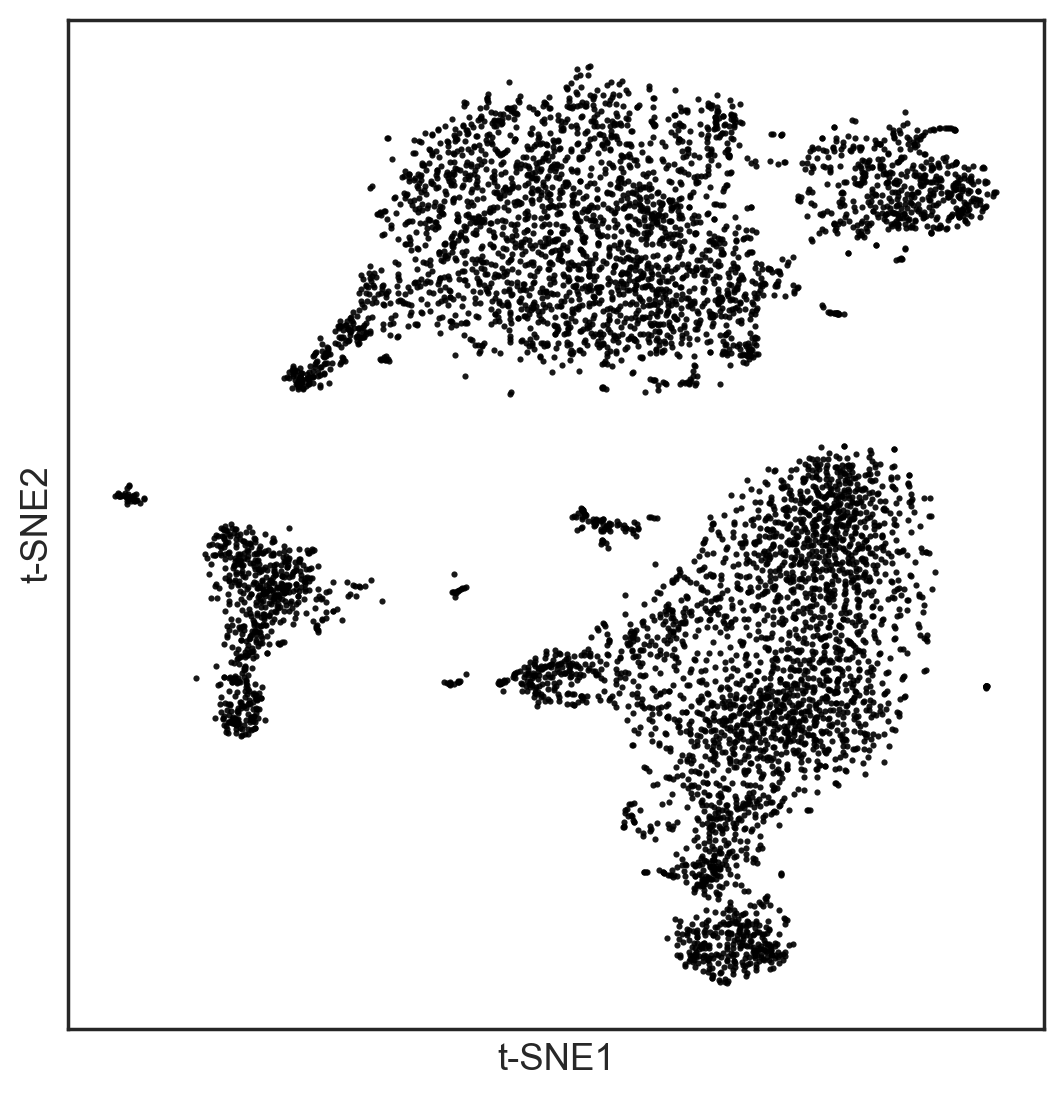

In [333]:
plot_tSNE(tsne_max_ns2)#,gene=('IL7R',['CD14', 'LYZ'],'MS4A1','CD8A',['FCGR3A', 'MS4A7']
                       #      ,['GNLY', 'NKG7'],['FCER1A', 'CST3'],'PPBP'))

In [504]:
#pop=np.log2(1+to_tpm(dfc[s_gen[s_gen>1200].index.tolist()]))#.corr(method='pearson')
pop=df4[esso3]#df4[s_gen[s_gen>400].index.tolist()]
h=hierarchical(pop.T,method='ward')#.corr(method='pearson'))

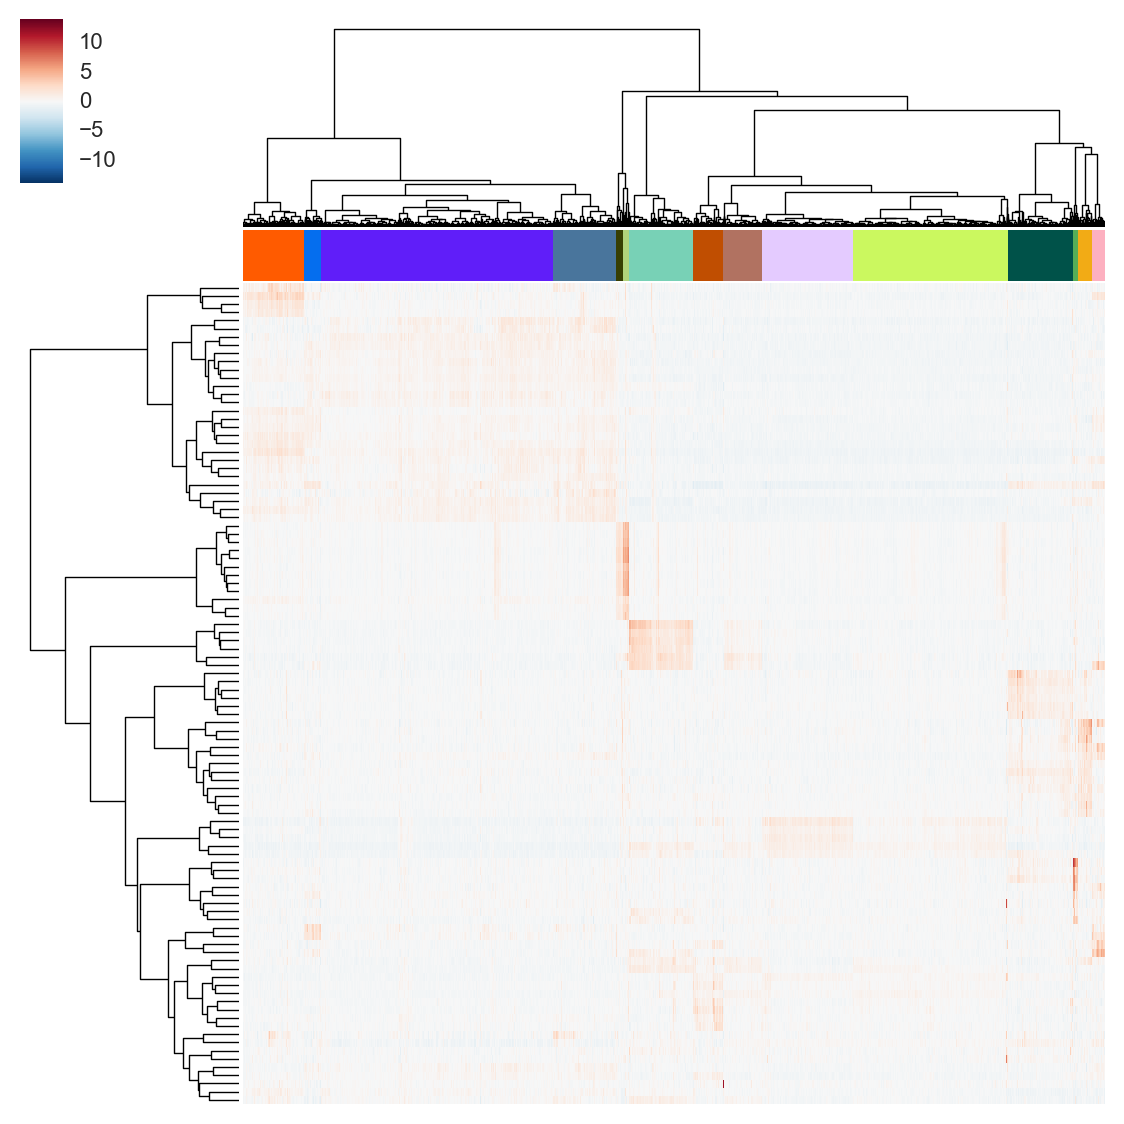

In [529]:
popul=populations(pop.T,h[0],h[1],thrs=43,ncolors=18,palette=pallete_20III)

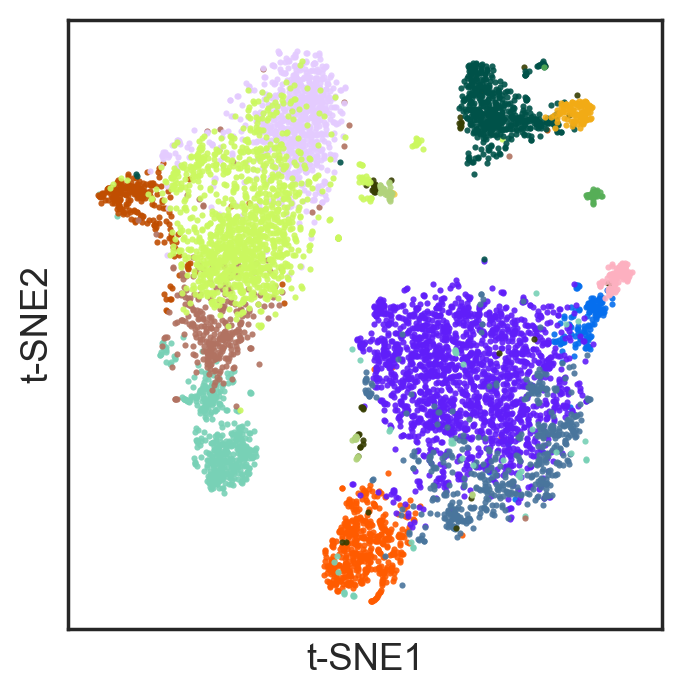

In [530]:
a=plot_populations(tsne_max_ns,popul,var='cell',cluster='all',get_cluster=False,size=4)


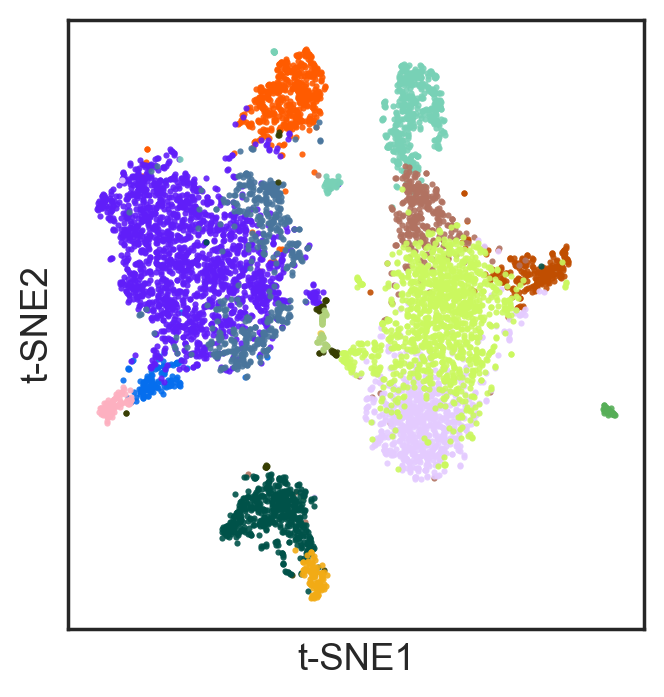

In [531]:
plot_populations(anda,popul,var='cell',cluster='all',get_cluster=False,size=4)

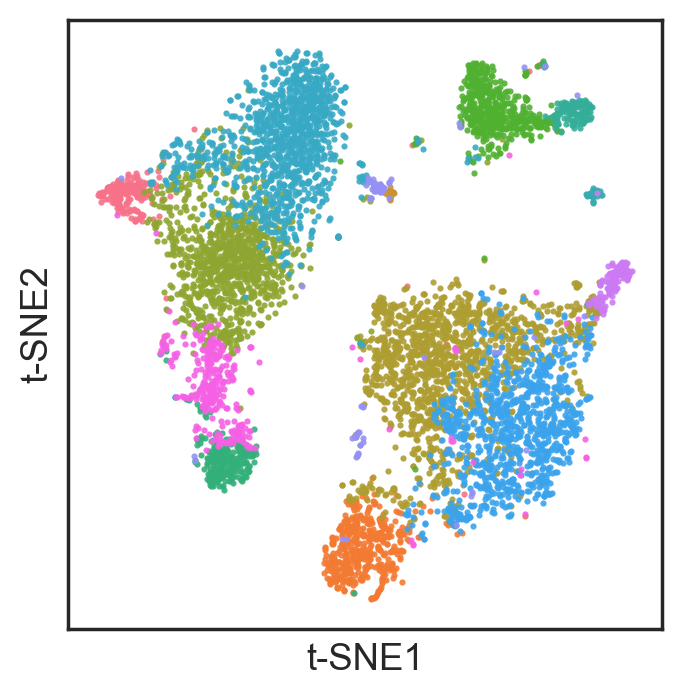

In [525]:
plot_clusters('kmeans',14,tsne_max_ns, pop, size=4,legend=False,get_cluster=False)

In [ ]:
#Info for the user

#a.to_csv('/Users/la2666/Downloads/AL_samples/{0}_clusters.txt'.format(name),sep='\t')
mat=df4[s_gen[s_gen>700].index.tolist()]
mat.loc[a.index,'clust']=a.loc[:,0]
#mat.to_csv('/Users/la2666/Downloads/AL_samples/{0}_clusters.txt'.format(name),sep='\t')

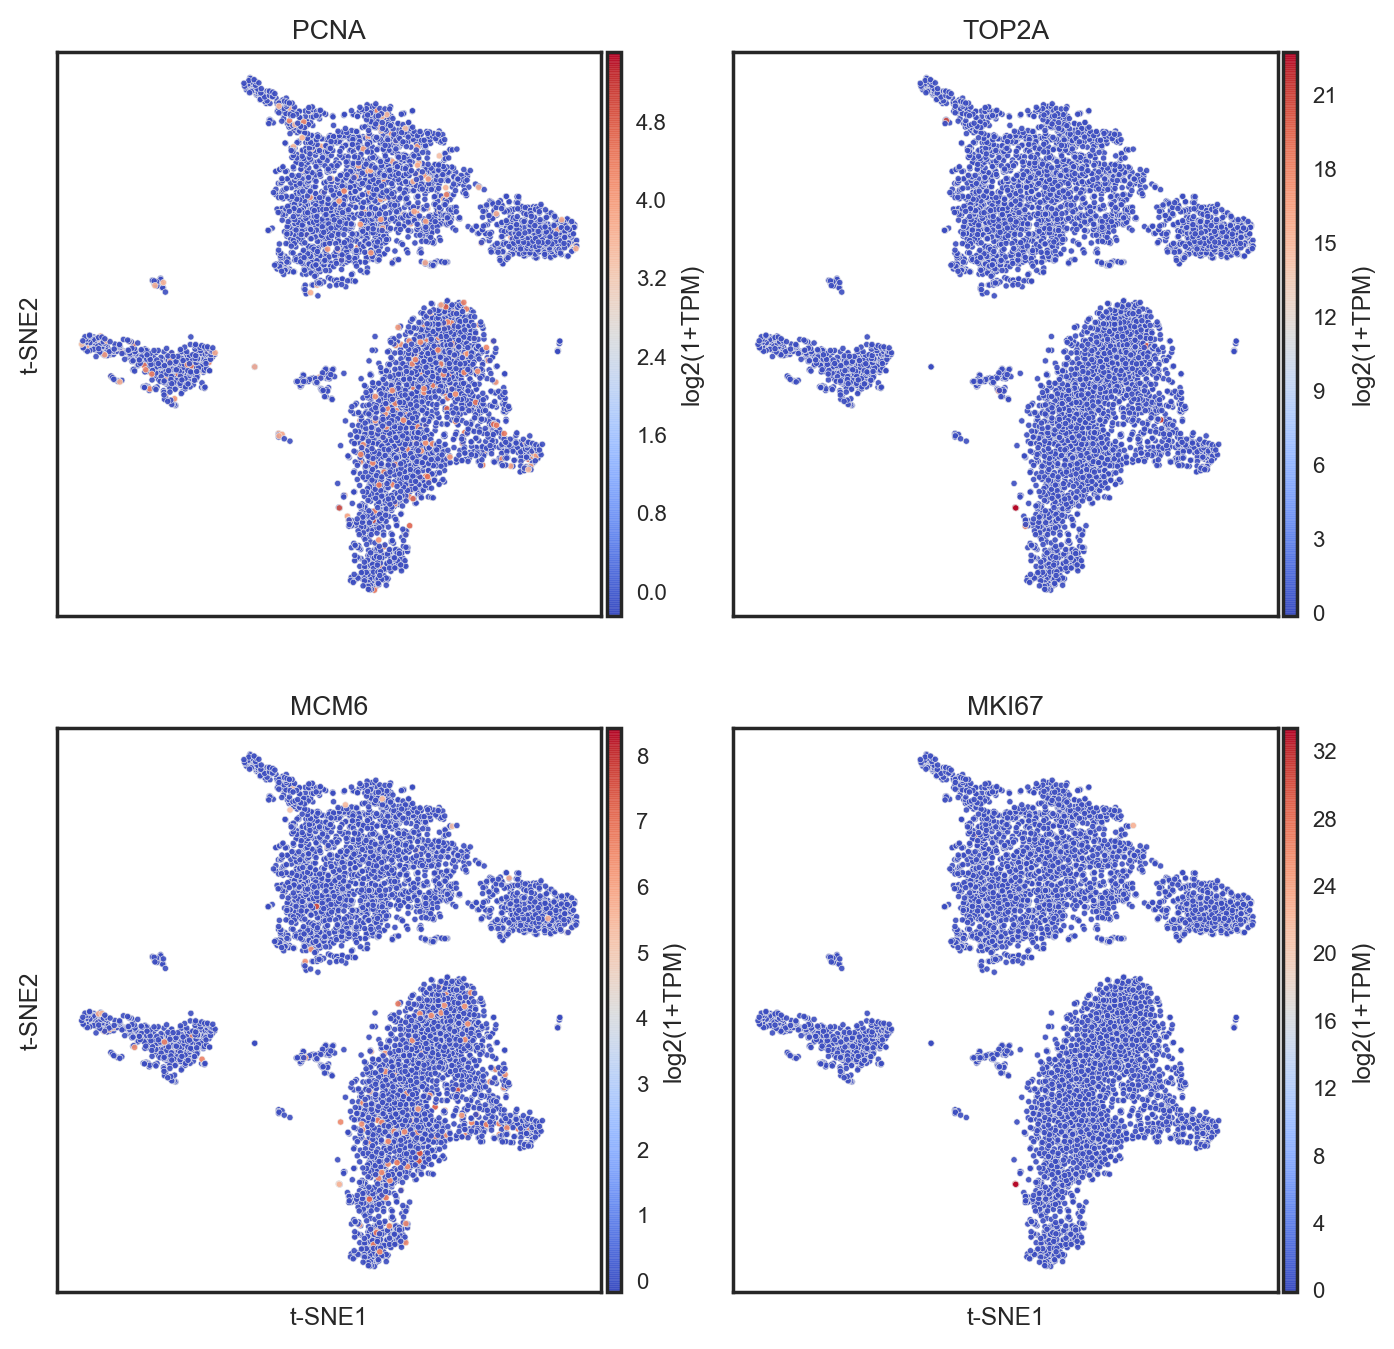

In [235]:
plot_tSNE(tsne_ns3,gene=('PCNA', 'TOP2A', 'MCM6', 'MKI67'),size=4)

### Other tsne 

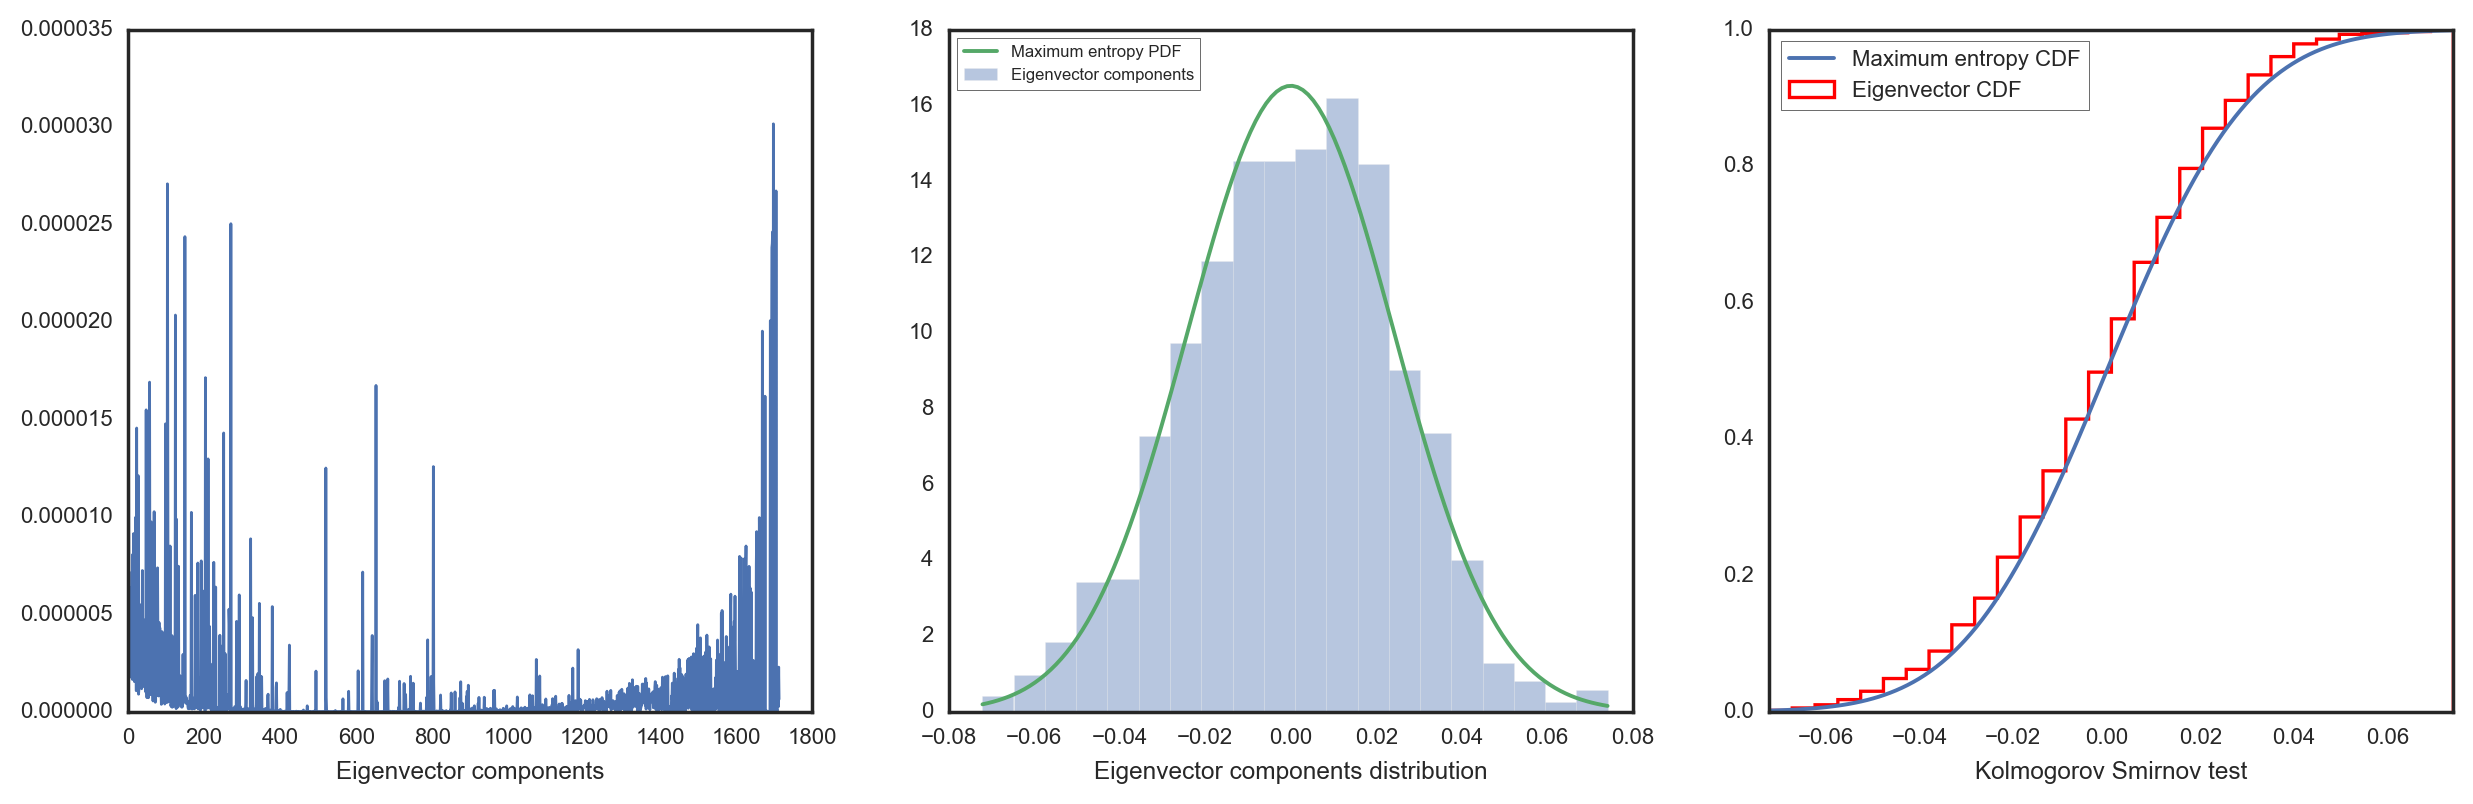

KstestResult(statistic=0.028764586558541638, pvalue=0.11503499896091474)

In [334]:
eign_entropy(V,len(V)-3)#,path='../../RandomMatrix/Supplementary Material/{0}_random_noclean_c50_entropy.pdf'.format(name))

In [164]:
tsne_rand=run_tSNE_par(pd.DataFrame(Yrm),10,'euclidean',pca=True,n_jobs=5)

In [386]:
#seurat like
raw2=raw.loc[(raw.T>0).sum()>199]    # filter out cells expressing less than 200 genes
raw2=np.log2(1+to_tpm(raw2.loc[:,(raw2>0).sum()>2]))       # filter out genes expressed in 3 or more cells
esso=np.log10((raw2.var()/raw2.mean()))
#tsne_seu=run_tSNE_par(np.log2(1+to_tpm(raw2)),37,'correlation')
#plot_tSNE(tsne_seu,size=4)

In [387]:
seur=((esso-esso.mean())/esso.var()).sort_values(ascending=False)[:1000].index.tolist()

In [388]:
len(list(set(seur).intersection(s1)))

77

In [1044]:
tsne_sel=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>150].index.tolist()])),76,'correlation')
tsne_sel2=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>300].index.tolist()])),76,'correlation')
tsne_sel3=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>500].index.tolist()])),76,'correlation')
tsne_sel4=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>600].index.tolist()])),76,'correlation')
tsne_sel5=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>900].index.tolist()])),76,'correlation')
tsne_sel6=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>400].index.tolist()])),76,'correlation')
tsne_sel7=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>350].index.tolist()])),76,'correlation')

In [785]:
tsne_sel7=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>450].index.tolist()])),37,'correlation')

In [830]:
tsne_sel8=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>280].index.tolist()])),47,'correlation')

In [83]:
tsne_ns=run_tSNE_par(df4[s_gen[s_gen>150].index.tolist()],83,'correlation',pca=True)
tsne_ns2=run_tSNE_par(df4[s_gen[s_gen>300].index.tolist()],83,'correlation',pca=True)
tsne_ns3=run_tSNE_par(df4[s_gen[s_gen>500].index.tolist()],83,'correlation',pca=True)
tsne_ns4=run_tSNE_par(df4[s_gen[s_gen>600].index.tolist()],83,'correlation',pca=True)
tsne_ns5=run_tSNE_par(df4[s_gen[s_gen>1000].index.tolist()],83,'correlation',pca=True)
tsne_ns6=run_tSNE_par(df4[s_gen[s_gen>400].index.tolist()],83,'correlation',pca=True)

In [503]:
esso=df4[s_gen[s_gen>800].index.tolist()]
esso2=esso.var()/esso.mean()
esso3=esso2.sort_values(ascending=False)[:100].index.tolist()

In [485]:
tsne_seu=run_tSNE_par(df4[esso3],20,'euclidean',pca=True)

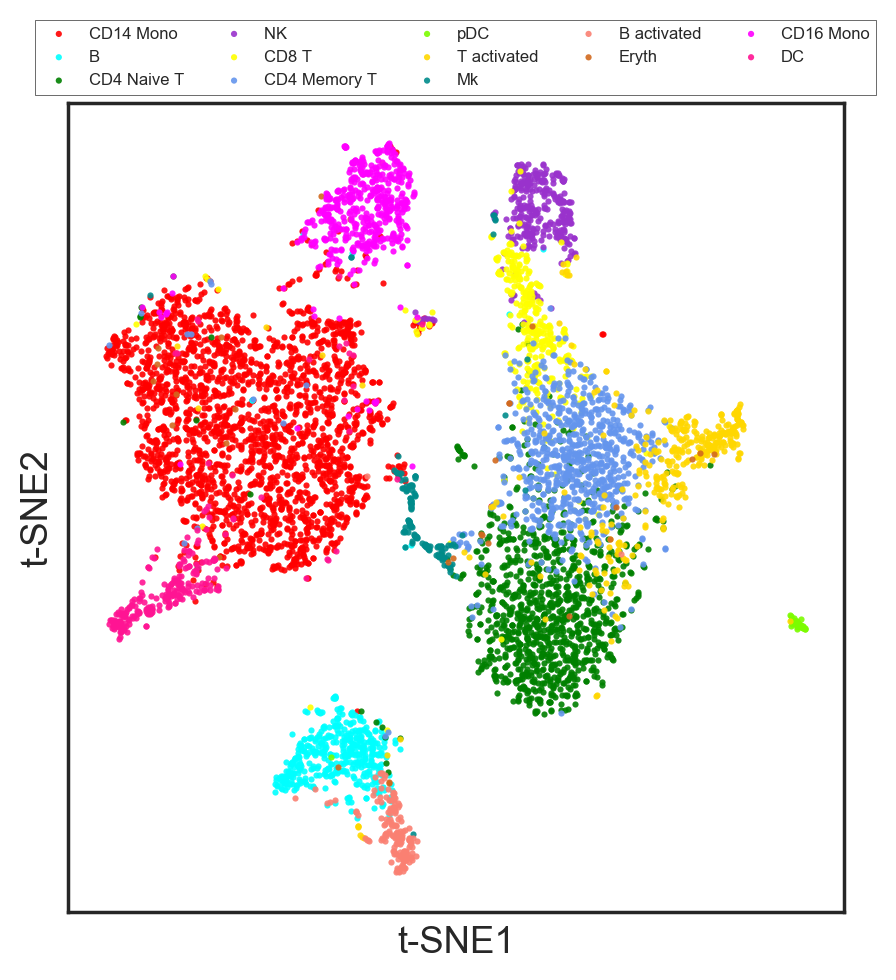

In [540]:
anda=tsne_seu
#plot_tSNE(anda,size=4)
pbmc_lab=anda.index.str.split('_').str[1].values.tolist()
plot_tSNE(anda, labels=pbmc_lab, palette=pbmc_kang, size=5)
#plot_populations(anda,popul,var='cell',cluster='all',get_cluster=False,size=4)


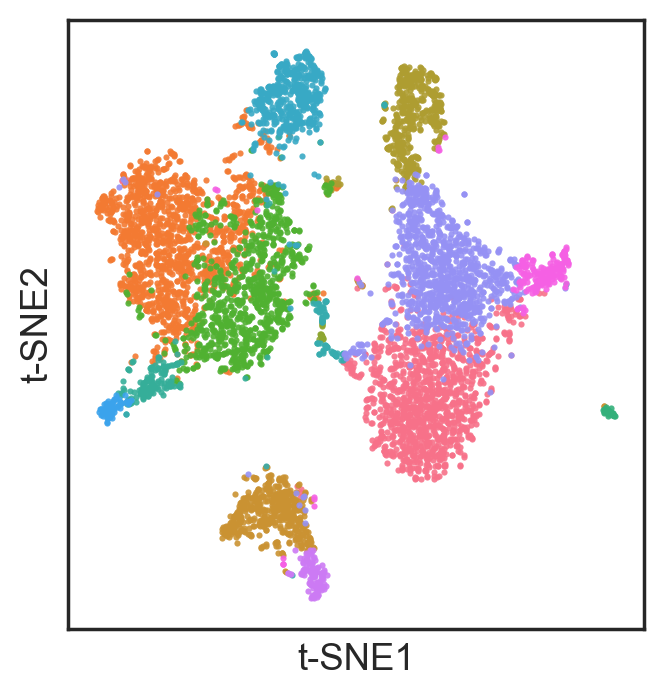

In [532]:
plot_clusters('kmeans',14,anda,df4[esso3],size=4,legend=False,get_cluster=False)

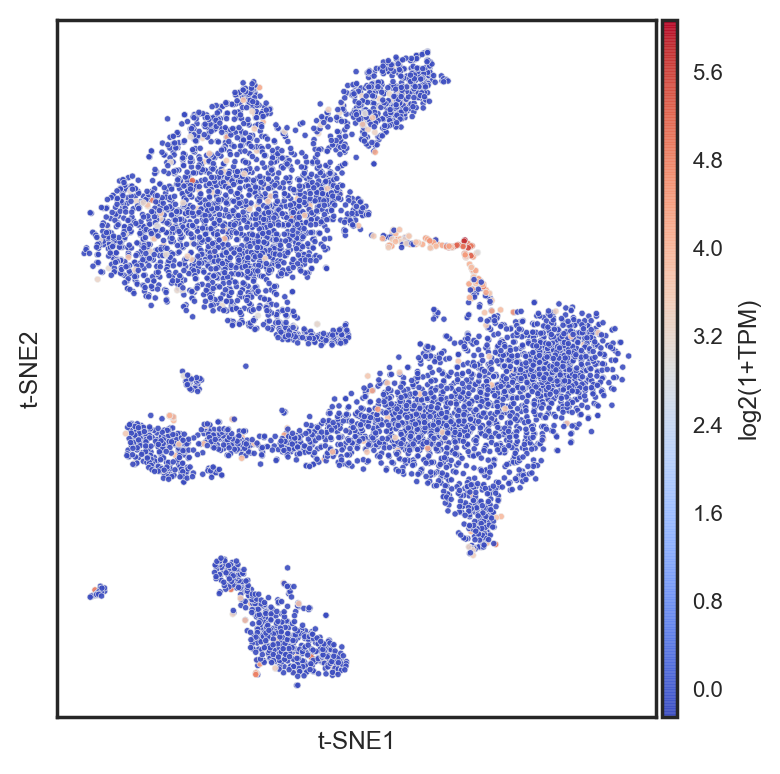

In [474]:
plot_tSNE(anda,gene=['PPBP'],size=4)


In [ ]:
tsne_pr=run_tSNE(np.log2(1+to_tpm(dfc[s_gen[s_gen>600].index.tolist()])),10,'correlation')
tsne_pr2=run_tSNE(df4[s_gen[s_gen>600].index.tolist()],10,'correlation')

In [ ]:
tsne_more=run_tSNE(np.log2(1+to_tpm(dfc[s_gen[s_gen>460].index.tolist()])),300,'correlation')
tsne_nsmore=run_tSNE(df4[s_gen[s_gen>720].index.tolist()],80,'correlation')

###  Pancreas

In [53]:
pancreas_in=['red', 'cyan','green', 'darkorchid','y','cornflowerblue','lawngreen'
                                        ,'gold','orange','salmon','darkcyan','crimson','fuchsia','chocolate'
                                        ]
pan_lab=tsne_max.index.str.split('-').str[2].values.tolist()

NameError: name 'tsne_max' is not defined

In [302]:
#dict(zip(pd.unique(tsne_max.index.str.split('-').str[2].values.tolist()).tolist(),pancreas_in))

In [303]:
dicol={'acinar': 'darkorchid',
 'activated_stellate': 'orange',
 'alpha': 'cyan',
 'beta': 'red',
 'delta': 'y',
 'ductal': 'green',
 'endothelial': 'lawngreen',
 'epsilon': 'crimson',
 'gamma': 'gold',
 'macrophage': 'darkcyan',
 'quiescent_stellate': 'cornflowerblue',
 'schwann': 'fuchsia',
 't_cell': 'salmon'}

In [304]:
pancreas=[dicol[i] for i in pd.unique(tsne_max.index.str.split('-').str[2].values.tolist()).tolist()]

In [305]:
pancreas#pd.unique(tsne_max.index.str.split('-').str[2].values.tolist()).tolist()

['green',
 'cyan',
 'orange',
 'red',
 'y',
 'darkcyan',
 'gold',
 'salmon',
 'cornflowerblue',
 'lawngreen',
 'fuchsia',
 'crimson',
 'darkorchid']

In [ ]:
plot_tSNE(tsne_max,labels=pan_lab,palette=pancreas,title='just selection max',size=5)
plot_tSNE(tsne_max2,labels=pan_lab,palette=pancreas,title='just selection first local max',size=5)
plot_tSNE(tsne_max3,labels=pan_lab,palette=pancreas,title='just selection third local max',size=5)

In [ ]:
plot_tSNE(tsne_max_ns,labels=pan_lab,palette=pancreas,title='just selection max',size=5)
plot_tSNE(tsne_max_ns2,labels=pan_lab,palette=pancreas,title='just selection first local max',size=5)
plot_tSNE(tsne_max_ns3,labels=pan_lab,palette=pancreas,title='just selection first local max',size=5)

In [ ]:
plot_tSNE(tsne_max_ns4,labels=pan_lab,palette=pancreas,title='just selection first local max',size=5)
plot_tSNE(tsne_max_ns5,labels=pan_lab,palette=pancreas,title='just selection first local max',size=5)

#### Ploting markers experiments 

In [ ]:
plot_tSNE(tsne_max2,gene=('library',['DDIT3','HSPA5','HERPUD1'],['MAFA','UCN3']),size=4)

In [ ]:
plot_tSNE(tsne_max2,gene=('MUC1','CFTR','TFF1','CD44'),size=4)

In [ ]:
plot_tSNE(tsne_max2,gene=('PPY','GCG','SST','INS','GHRL','CPA1','KRT19'
                          ,'RGS5','PDGFRA','VWF','SDS','TRAC','SOX10'))

###  Populations

In [ ]:
#pop=np.log2(1+to_tpm(dfc[s_gen[s_gen>800].index.tolist()]))#.corr(method='pearson')
#pop=dfc[s_gen[s_gen>460].index.tolist()]#.corr(method='pearson')
#pop=to_tpm(dfc[s_gen[s_gen>460].index.tolist()])#.corr(method='pearson')

pop=df4[s_gen[s_gen>760].index.tolist()]#.corr(method='pearson')

In [ ]:
gC = sns.clustermap(pop.T,method="ward",
                   linewidths=0, xticklabels=False, yticklabels=False, 
                    cbar_kws={"orientation": "vertical"}, figsize=(7, 7), center=0)
#                    ,col_colors=[dicol[i] for i in pan_lab] )
plt.show()

In [ ]:
popul2=populations(pop.T,method='ward',thrs=12,ncolors=20)

In [ ]:
plot_populations(tsne_max2,popul2,var='gene',cluster='all',size=3)

In [ ]:
#pop=np.log10(1+to_tpm(dfc[s_gen[s_gen>600].index.tolist()]))#.corr(method='pearson')
pop=df4[s_gen[s_gen>1000].index.tolist()]#.corr(method='pearson')

In [ ]:
popul=populations(pop.T,method='ward',thrs=50,ncolors=18,cell_label=[dicol[i] for i in pan_lab],palette=pallete_20III)

In [ ]:
a=plot_populations(tsne_max2,popul,var='cell',cluster='all',get_cluster=False)
plot_tSNE(tsne_max2,labels=pan_lab,palette=pancreas,size=4)

### Labels and palettes for populations

In [41]:
import matplotlib as mpl
embrio_mouse=mpl.colors.ListedColormap(['red', 'cyan','green', 'darkorchid','yellow','cornflowerblue','lawngreen'
                                        ,'gold','darkcyan','salmon','chocolate','fuchsia','deeppink'
                                        ,'deeppink','deeppink','deeppink'])

#cortex_mouse_9=mpl.colors.ListedColormap(['cyan', 'cyan','cyan', 'cyan','cyan','cyan','red'
#                                         ,'cyan','cyan','cyan','cyan','cyan','cyan',
#                                         'cyan','cyan'])

cortex_mouse_9=mpl.colors.ListedColormap(['white', 'cyan','green', 'darkorchid','fuchsia','darkorchid','lawngreen'
                                         ,'gold','darkcyan','chocolate','gold','fuchsia','fuchsia',
                                         'coral','chocolate'])

cortex_mouse_7=mpl.colors.ListedColormap(['cyan', 'cyan','cyan', 'cyan','cyan','cyan','red'])

pbmc_kang=['red', 'cyan','green', 'darkorchid','yellow','cornflowerblue','lawngreen'
                                        ,'gold','darkcyan','salmon','chocolate','fuchsia','deeppink'
                                        ]

pancreas=mpl.colors.ListedColormap(['red', 'cyan','green', 'darkorchid','yellow','cornflowerblue','lawngreen'
                                        ,'gold','orange','salmon','chocolate','fuchsia','crimson','darkcyan'
                                        ])
#pancreas=mpl.colors.ListedColormap(['green', 'red','cyan', 'yellow'])

mycol=pbmc_kang#pancreas#cortex_mouse_9


In [ ]:
# pbmc_pancreas
labels=pd.DataFrame(raw.index.str.split('-').str[2].values,index=raw.index,columns=['class'])

In [40]:
# pbmc_kang
labels=pd.DataFrame(raw.index.str.split('_').str[1],index=raw.index,columns=['class'])

In [ ]:
# mouse cortex 
labels=pd.DataFrame(raw.index.str.split('.').str[0].str.split('_').str[0].str[:2],index=raw.index,columns=['class'])

In [ ]:
# mouse cortex
labels=pd.DataFrame(raw.index.str.split('.').str[0].str.split('_').str[1],index=raw.index,columns=['class'])

In [ ]:
# mouse embrio
labels=pd.DataFrame(raw.index.str.split('_').str[1],index=raw.index,columns=['class'])

In [ ]:
#human embrio
labels=pd.DataFrame(raw.index.str.split('_').str[0].str.split('.').str[1],index=raw.index,columns=['class'])

In [ ]:
unique_labels = list(np.unique(labels['class']))                
mapped_labels = {l: i for i, l in enumerate(unique_labels)}
labels['class_mapped'] = [mapped_labels[l] for l in labels['class']]

#  Other  things

In [1]:
pthrs=0.1
sch=pd.DataFrame(Lc)
pcell=[]
kcell=[]
essa=[]
plt.figure()
for i in sch[0].sort_values(ascending=True)[1:200].index.tolist():
    pp=pd.DataFrame(Vc.T[i]**2).reset_index();
    if abs(pp[0]).max()>pthrs:
        #kcell.append(pp[pp[0]>pthrs]['index'].values.tolist())
        prob=(pp[0]>pthrs).sum()/float(len(pp))
        essa.append(i)
        plt.plot(pp['index'].values,pp[0].values,lw=1)
plt.show()
print essa

NameError: name 'pd' is not defined

In [2]:
genesprojC=np.dot(df2.values.T,(1*Vc)[:,:])
cellsprojC=np.dot(df2.values,np.dot(df2.values.T,(1*Vc)[:,:]))


distgen2C=np.apply_along_axis(my_func, 0, genesprojC[:,:])
distgen3C=np.apply_along_axis(my_func, 0, cellsprojC[:,:])

fig = plt.figure(figsize=[17, 5])
plt.plot(1-distgen2C[1:])
#plt.plot(1-distgen3C[1:])
plt.xlim([-50,len(Vc)+50])
#plt.ylim([-0.05,1])
plt.ylabel('Shapiro normality Distance')
plt.xlabel('Ranked Eigenvectors')
#plt.ylim([0,0.5])
plt.xticks(np.arange(0, len(distgen2C)+50, 100.0))
plt.grid()
#plt.legend(['Randomized data','Data'], loc="upper right",frameon=True)
plt.show()

NameError: name 'np' is not defined

In [3]:
Mr=Yrc
M=Yr

mat=pd.DataFrame(Mr)
mat2=pd.DataFrame(M)
eso=pd.Series(np.diag(mat), index=[mat.index]).sort_values(ascending=True)
eso2=pd.Series(np.diag(mat2), index=[mat2.index]).sort_values(ascending=True)

Yr_ord=mat.loc[eso.index][eso.index] #ordered by diagonal elemnts from small to big
Y_ord=mat2.loc[eso2.index][eso2.index]


suma=[]
suma2=[]
sumar=[]
sumar2=[]
for i in eso.index:
    #sumar.append((pd.DataFrame(Yr)[i]**1).sum())
    sumar2.append(max(abs(pd.DataFrame(Mr)[i])-1))
for i in eso2.index:
    #suma.append((pd.DataFrame(Y)[i]**1).sum())
    suma2.append(max(abs(pd.DataFrame(M)[i])-1))


# plt.plot(range(0, Yr.shape[0],1),sumar)
# plt.plot(range(0, Y.shape[0],1),suma)
# plt.show()
fig = plt.figure(figsize=[14, 5])
plt.plot(range(0, Mr.shape[0],1),sumar2)
plt.plot(range(0, M.shape[0],1),suma2)
plt.axhline(y=0,ls='--',color=sns.xkcd_rgb["greyish"])
y1=max(sumar2)
y2=min(sumar2)

y1=0.07
y2=-0.07
x=np.arange(0, M.shape[0],1)
plt.fill_between(x, y1, y2,color='y',alpha=.3)

#plt.xlim(-10, 2500)
plt.ylim(-max(suma2)+0.1,max(suma2)+0*0.1)

plt.ylim(-0.2,0.2)


#plt.axvline(x=480,ls='--',color=sns.xkcd_rgb["greyish"])
#plt.axvline(x=640,ls='--',color=sns.xkcd_rgb["greyish"])
plt.xlabel('Wishart vectors ordered by its maximal component')
plt.ylabel('maximal component  - 1')
plt.xlim([-50,len(Vc)+50])


plt.axhline(y=-0.5,ls='--',color=sns.xkcd_rgb["greyish"])

plt.show()
print max(suma2), min(suma2)
print max(sumar2), min(sumar2)

NameError: name 'Yrc' is not defined

In [4]:
eign_entropy(Vrc,len(Vrc)-1,path='../New_figures/{0}_dist_clean.pdf'.format(name))

NameError: name 'eign_entropy' is not defined

In [5]:
eign_entropy(Vr,len(Vr)-3,path='../New_figures/{0}_dist_no_clean.pdf'.format(name))

NameError: name 'eign_entropy' is not defined

In [6]:
eign_entropy(Vr,len(V)-1)

NameError: name 'eign_entropy' is not defined

In [7]:
dict_genes.keys()[dict_genes.values().index('virus')]

NameError: name 'dict_genes' is not defined

In [ ]:
cormat=df32.iloc[:, :200].corr(method='pearson')

In [ ]:
esto=pd.DataFrame([0]*50+[1]*150,index=cormat.index).astype(str)

In [ ]:
esto

In [ ]:
(U, S, V) = linalg.svd(pd.DataFrame(Yrm), full_matrices=False)
S[np.square(S)/df.shape[1]<_tw(Lr,Lr)]=0
df4=pd.DataFrame(np.dot(np.dot(U,np.diag(S)),V))
df4.columns=df.columns
df4.index=df.index
df4.to_csv('../{0}_denoised_R.txt'.format(name),sep='\t')

#### Comparing sigmoids 

In [ ]:
eso=pd.read_table('../ad_experimentum/{0}_denoised_by_selection_min.txt'.format(name),sep='\t',index_col=0)
eso2=raw
#eso=eso[eso.var().sort_values()[-2000:].index]
#eso2=eso2[eso2.var().sort_values()[-2000:].index]


sns.regplot((raw.mean()),(raw>0).sum()/raw.shape[0],scatter=True,fit_reg=False, scatter_kws={'s':2\
                ,'color':sns.xkcd_rgb["bright blue"]})
#sns.regplot((dfc.mean()),(dfc>0).sum()/dfc.shape[0],scatter=True,fit_reg=False, scatter_kws={'s':2\
#                ,'color':sns.xkcd_rgb["cherry red"]})
sns.regplot((eso.mean()),(eso>0).sum()/raw.shape[0],scatter=True,fit_reg=False, scatter_kws={'s':2\
                ,'color':sns.xkcd_rgb["grass green"]})
#sns.regplot((eso2.mean()),(eso2>0).sum()/raw.shape[0],scatter=True,fit_reg=False, scatter_kws={'s':1\
#                ,'color':sns.xkcd_rgb["pink"]})
plt.gca().set_xscale("log")
plt.ylabel('Fraccion of cells expressing a gene')
plt.xlabel('Average gene expression')
plt.ylim(-0.05,1.05)
plt.show()

In [ ]:
dfc.shape

In [ ]:
eso2.T.index.intersection(eso.T.index)

### Sillhouette

In [ ]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

In [ ]:
den5=pd.read_table('../ad_experimentum/{0}_denoised_by_selection_10-3.txt'.format(name),sep='\t',index_col=0)
den5.shape

In [ ]:
metrics.silhouette_score(raw, labels['class_mapped'].tolist(), metric='correlation')

In [ ]:
metrics.silhouette_score(den, labels['class_mapped'].tolist(), metric='correlation')

In [ ]:
metrics.silhouette_score(den2, labels['class_mapped'].tolist(), metric='correlation')

In [ ]:
metrics.silhouette_score(den3, labels['class_mapped'].tolist(), metric='correlation')

In [ ]:
metrics.silhouette_score(den4, labels['class_mapped'].tolist(), metric='correlation')

In [ ]:
metrics.silhouette_score(den5, labels['class_mapped'].tolist(), metric='correlation')

In [ ]:
metrics.silhouette_score(raw[raw.var().sort_values()[-500:].index], labels['class_mapped'].tolist(), metric='correlation')

In [ ]:
den5.var().sort_values()[-500:].index.intersection(raw.var().sort_values()[-500:].index)

In [ ]:
sil_vals=[]
for i in range(0,int(round(max(s))),40):
    sil_vals.append(metrics.silhouette_score(dfc[s_gen[s_gen>i].index.tolist()]\
                                      , labels['class_mapped'].tolist(), metric='correlation'))

In [ ]:
sil_vals2=[]
for i in range(0,int(round(max(s))),40):
    sil_vals2.append(metrics.silhouette_score(df4[s_gen[s_gen>i].index.tolist()]\
                                      , labels['class_mapped'].tolist(), metric='correlation'))

In [ ]:
maxs=detect_pick(sil_vals,range(0,int(round(max(s))),40),0.005,'max')
maxs2=detect_pick(sil_vals2,range(0,int(round(max(s))),40),0.01,'max')


plt.plot(range(0,int(round(max(s))),40),np.nan_to_num(sil_vals),color=sns.xkcd_rgb["leaf green"],lw=2)
plt.plot(range(0,int(round(max(s))),40),sil_vals2,color=sns.xkcd_rgb["cerulean"],lw=2)
plt.scatter(maxs[0],maxs[1],s=15,color=sns.xkcd_rgb["bright red"])
plt.scatter(maxs2[0],maxs2[1],s=15,color=sns.xkcd_rgb["bright red"])

plt.grid()
plt.legend(['Non Nullified data','Nullified data'], loc="lower left",frameon=True)
plt.ylim(0,0.65)
plt.xlabel('Chi-squared test for variance (Normalized sample variance)')
plt.ylabel('Silhouette score')
plt.xlim(-15,max(scope)+20)

for i in range(0,len(maxs[0])):
    plt.text(maxs[0][i], maxs[1][i]+0.01, maxs[0][i], fontsize=7)
    
for i in range(0,len(maxs2[0])):
    plt.text(maxs2[0][i], maxs2[1][i]+0.01, maxs2[0][i], fontsize=7)
    
#plt.savefig('../{0}_silouhette.pdf'.format(name))
plt.show()

In [ ]:
#s correponding to max
range(0,int(round(max(s))),20)[sil_vals.index(max(sil_vals))]


In [ ]:
sil_2=pd.read_table('../ad_experimentum_2/silhouette_null.txt',header=None, index_col=0)


In [ ]:
sil_1=pd.read_table('../ad_experimentum_2/silhouettes.txt',header=None, index_col=0)


In [ ]:
plt.figure(figsize=(5,5))
plt.plot(range(0,int(round(max(s))),10),np.nan_to_num(sil_1.index),color=sns.xkcd_rgb["leaf green"],lw=2)
plt.plot(range(0,int(round(max(s))),10),np.nan_to_num(sil_2.index),color=sns.xkcd_rgb["cerulean"],lw=2)
plt.plot(0,0.183,'*',color=sns.xkcd_rgb["scarlet"],markersize=10)
plt.plot(0,0.169,'<',color=sns.xkcd_rgb["burnt yellow"],markersize=8)
plt.grid()
plt.legend(['Non Nullified data','Nullified data','Raw data','500 most variant genes in raw data'], loc="lower left",frameon=True)
plt.ylim(0,0.5)
plt.xlabel('Chi-squared test for variance (Normalized sample variance)')
plt.ylabel('Silhouette score')
plt.savefig('../{0}_silouhette.pdf'.format(name))
plt.show()

In [ ]:
highexp=pd.read_table('../ad_experimentum_2/mouse_cortex_trimmed_genes_high_expression.txt', header=None)

In [ ]:
raw_high=raw.drop(highexp[0].values.tolist(),axis=1)

In [ ]:
metrics.silhouette_score(raw_high, labels['class_mapped'].tolist(), metric='correlation')

### Cosas

In [ ]:
b1=pd.read_table('../../GSE84133_RAW/GSM2230757_human1_umifm_counts.csv', sep=',', index_col=0);
b2=pd.read_table('../../GSE84133_RAW/GSM2230758_human2_umifm_counts.csv', sep=',', index_col=0);
b3=pd.read_table('../../GSE84133_RAW/GSM2230759_human3_umifm_counts.csv', sep=',', index_col=0);
b4=pd.read_table('../../GSE84133_RAW/GSM2230760_human4_umifm_counts.csv', sep=',', index_col=0);

In [ ]:
conv=pd.read_table('../../GSE84133_RAW/meta_data_pancreas.tsv',index_col=0)

In [ ]:
bf=pd.concat([b1,b2,b3,b4])

In [ ]:
bf=bf.T[conv[conv['Species']=='human'].index].T

In [ ]:
conv2=conv[conv['Species']=='human']

In [ ]:
bf.index=bf.index+'-'+conv2['Cluster_ID']+'-'+conv2['Baron_Cluster_ID']

In [ ]:
bf.T.loc[bf.any()!=0].T.to_csv('../Data/pancreas_annotated.txt',sep='\t')

### Compariosn scImpute

In [ ]:
sci=pd.read_table('../../sc/data/imputed/scimpute/preliminary/pbmc_ctrl_annotated/pbmc_ctrl_annotated_k13_t0.5_scimpute_count.txt',index_col=0,sep=' ').T

In [ ]:
sci_2=pd.read_table('../../sc/data/imputed/scimpute/preliminary/pbmc_ctrl_annotated/pbmc_ctrl_annotated_k10_t0.5_scimpute_count.txt',index_col=0,sep=' ').T

In [ ]:
sci_3=pd.read_table('../../sc/data/imputed/scimpute/preliminary/pbmc_ctrl_annotated/pbmc_ctrl_annotated_k15_t0.5_scimpute_count.txt',index_col=0,sep=' ').T

In [ ]:
sci_4=pd.read_table('../../sc/data/imputed/scimpute/preliminary/pbmc_ctrl_annotated/pbmc_ctrl_annotated_k12_t0.5_scimpute_count.txt',index_col=0,sep=' ').T

In [ ]:
sci_5=pd.read_table('../../sc/data/imputed/scimpute/preliminary/pbmc_ctrl_annotated/pbmc_ctrl_annotated_k11_t0.5_scimpute_count.txt',index_col=0,sep=' ').T

In [ ]:
tsne_sci=run_tSNE(np.log2(1+to_tpm(sci)),10,'correlation')


In [ ]:
tsne_sci3=run_tSNE(np.log2(1+to_tpm(sci)),50,'correlation')


In [ ]:
tsne_sci2=run_tSNE(np.log2(1+to_tpm(sci_2)),10,'correlation')


In [ ]:
tsne_sci4=run_tSNE(np.log2(1+to_tpm(sci_3)),10,'correlation')


In [ ]:
tsne_sci5=run_tSNE(np.log2(1+to_tpm(sci)),70,'correlation')


In [ ]:
tsne_sci6=run_tSNE(np.log2(1+to_tpm(sci_4)),10,'correlation')


In [ ]:
tsne_sci7=run_tSNE(np.log2(1+to_tpm(sci_5)),10,'correlation')


In [ ]:
tsne_sci7.index=labels.index


In [ ]:
plot_tSNE_markers2(tsne_sci7, ['class_mapped'], labels,title='scimpute k=11 and pca_comp=10',path='../{0}_k11_10comp.pdf'.format(name))

In [ ]:
scim=pd.read_table('../../sc/data/imputed/scimpute/preliminary/mouse_cortex/mouse_cortex_scImpute_k4_t0.5_scimpute_count.txt',index_col=0,sep=' ').T

In [ ]:
tsne_scim=run_tSNE(np.log2(1+to_tpm(scim)),10,'correlation')


In [ ]:
tsne_scim.index=labels.index


In [ ]:
plot_tSNE_markers2(tsne_scim, ['class_mapped'], labels,title='scimpute k=7 and pca_comp=10',path='../{0}_1.pdf'.format(name))

In [ ]:
tsne_scim.shape


## Biggest palette ever (by xkcd)

In [ ]:
pallete_20=['#eecffe', '#056eee', '#ca6641', '#49759c', '#373e02', '#f4d054', '#b1d27b', '#78d1b6', '#c04e01',
 '#fffd37', '#ff69af', '#ff796c', '#4f9153', '#f9bc08', '#8d8468', '#947706', '#fdb0c0',
 '#c87f89', '#ff5b00', '#601ef9']


In [ ]:
print palette_clust


In [ ]:
xkcol=['light eggplant', 'pea green', 'french blue', 'sapphire', 'orangish brown', 'light olive green', 'pinkish tan',
       'custard', 'pale light green', 'carolina blue', 'light teal', 'blueberry', 'celery', 'purpley blue', 
       'deep brown', 'olive brown', 'light gold', 'mulberry', 'tea', 'blue/grey', 'bluish purple', 'green brown', 
       'baby poo', 'light urple', 'sea', 'sienna', 'grey green', 'brown red', 'dark olive green', 'yellowish', 
       'soft green', 'pastel green', 'poo', 'leaf green', 'lichen', 'purply', 'neon red', 'purplish brown', 'deep red',
       'brick', 'bright red', 'toxic green', 'pumpkin', 'light lime', 'grass green', 'algae green', 'steel blue', 
       'vomit', 'wine', 'royal purple', 'dark seafoam green', 'muddy green', "robin's egg", 'light lavendar',
       'sickly yellow', 'sky', 'mocha', 'light aqua', 'sunny yellow', 'neon green', 'brownish red', 'yellowish orange',
       'muddy brown', 'moss green', 'brown yellow', 'wheat', 'dark green blue', 'darkish green', 'fern', 'purply pink', 
       'pinkish red', 'pale purple', 'dark green', 'steel grey', 'windows blue', 'vomit yellow', 'blue/green', 
       'light navy', 'brownish purple', 'warm blue', 'faded blue', 'cherry', 'bluish', 'teal', 'boring green', 
       'deep magenta', 'tiffany blue', 'faded purple', 'grey/blue', 'very light brown', 'deep lilac', 'greenish brown',
       'very light purple', 'grey teal', 'deep sea blue', 'pale', 'sepia', 'lightish red', 'pale aqua', 'raspberry', 
       'purple brown', 'flat green', 'greeny brown', 'rosy pink', 'vermillion', 'old pink', 'orange yellow', 'peach',
       'light sky blue', 'brownish orange', 'ugly green', 'deep blue', 'reddish orange', 'dusty rose', 'dark turquoise', 
       'pale gold', 'booger green', 'rust', 'stone', 'rose red', 'red pink', 'pinky purple', 'mahogany', 'lightish purple', 
       'putty', 'dusky pink', 'poison green', 'manilla', 'deep sky blue', 'perrywinkle', 'purplish pink', 'olive',
       'tealish green', 'irish green', 'violet blue', 'dark lime', 'peacock blue', 'butterscotch', 'dirty orange',
       'dark rose', 'deep teal', 'hospital green', 'lighter green', 'light aquamarine', 'light blue grey', 'lime yellow',
       'heliotrope', 'dark red', 'rust orange', 'sickly green', 'pastel pink', 'mustard yellow', 'dusty lavender',
       'kelly green', 'jade green', 'deep aqua', 'kiwi', 'sandy', 'rouge', 'light greenish blue', 'baby puke green',
       'golden rod', 'dusty purple', 'chestnut', 'cerulean blue', 'pig pink', 'bright lilac', 'piss yellow', 'bluish grey',
       'bright lime green', 'greyblue', 'golden yellow', 'dark navy', 'warm brown', 'purpley grey', 'greyish green',
       'foam green', 'avocado', 'dark navy blue', 'army green', 'brown orange', 'greeny yellow', 'duck egg blue',
       'dark sky blue', 'puce', 'orangey brown', 'pear', 'purply blue', 'red violet', 'baby shit green', 'purple',
       'umber', 'pinkish orange', 'pale yellow', 'yellow orange', 'faded yellow', 'orangish', 'gold', 'fuchsia',
       'pinkish grey', 'lipstick', 'battleship grey', 'bright yellow green', 'sand brown', 'light lime green',
       'asparagus', 'emerald', 'pale lime green', 'cinnamon', 'kiwi green', 'canary yellow', 'pale teal',
       'very dark purple', 'muted pink', 'egg shell', 'light grey blue', 'turtle green', 'blue', 'powder blue',
       'cement', 'greenish tan', 'dusk blue', 'camel', 'chartreuse', 'raw umber', 'sap green', 'green', 'light blue',
       'orange', 'ugly purple', 'pea soup', 'puke yellow', 'coffee', 'light light blue', 'camo', 'toupe', 'dark mint',
       'sage', 'shit brown', 'puke green', 'aqua marine', 'dull teal', 'light forest green', 'dark cream', 'dark peach',
       'blue purple', 'melon', 'blue violet', 'dust', 'bubble gum pink', 'cyan', 'light sea green', 'tealish',
       'light seafoam green', 'dull blue', 'reddish purple', 'deep green', 'dark pastel green', 'medium brown',
       'rose', 'slate green', 'wisteria', 'denim', 'chocolate', 'aquamarine', 'red purple', 'rusty orange',
       'darkish purple', 'spring green', 'spruce', 'vibrant blue', 'very pale green', 'faded green', 'brownish', 
       'medium blue', 'dark pink', 'neon pink', 'squash', 'fawn', 'butter', 'baby poop', 'poo brown', 'bright purple',
       'goldenrod', 'ugly blue', 'deep rose', 'sandy yellow', 'dusky blue', 'tea green', 'amber', 'yellow brown',
       'military green', 'kelley green', 'sand', 'green/blue', 'pale green', 'bluegrey', 'plum purple', 'carmine',
       'straw', 'coral', 'eggplant purple', 'orange pink', 'purple blue', 'terracotta', 'dusty pink', 'acid green',
       'lavender', 'lightgreen', 'dull yellow', 'greenish', 'sunflower', 'dark khaki', 'pale mauve', 'prussian blue',
       'hot pink', 'light mint green', 'light bluish green', 'cloudy blue', 'yellowy green', 'ochre', 'poop brown',
       'yellow ochre', 'yellow green', 'greyish brown', 'purple/pink', 'pale rose', 'reddy brown', 'ocean blue',
       'greenish yellow', 'lime', 'grape purple', 'teal blue', 'medium pink', 'brownish grey', 'spearmint',
       'aubergine', 'blue green', 'gunmetal', 'pine', 'terra cotta', 'lighter purple', 'dusty blue', 'clear blue',
       'fresh green', 'off green', 'light grey green', 'bruise', 'pastel red', 'saffron', 'light orange',
       'dark forest green', 'lavender blue', 'light maroon', 'yellowish green', 'peachy pink', 'dark plum',
       'seaweed', 'clay', 'light sage', 'dodger blue', 'primary blue', 'stormy blue', 'pale salmon', 'metallic blue',
       'mustard green', 'bright magenta', 'pale cyan', 'lime green', 'washed out green', 'light magenta', 'pistachio',
       'light turquoise', 'dark beige', 'light red', 'shit green', 'coral pink', 'diarrhea', 'ice', 'gross green', 'heather', 
       'denim blue', 'light periwinkle', 'terracota', 'fern green', 'muted blue', 'blue blue', 'turquoise', 'aqua blue',
       'bright yellow', 'rust red', 'electric green', 'bright light blue', 'aqua', 'reddish brown', 'highlighter green',
       'electric purple', 'very light green', 'purple pink', 'dark cyan', 'sun yellow', 'dark yellow', 'strawberry',
       'charcoal', 'ultramarine', 'dark sea green', 'iris', 'pale sky blue', 'reddish', 'light indigo', 'sandy brown',
       'orangeish', 'jungle green', 'darkish pink', 'dark lavender', 'ugly yellow', 'marine', 'grey/green', 'silver',
       'fluorescent green', 'light grey', 'lightish blue', 'butter yellow', 'mint', 'bright lime', 'avocado green',
       'black', 'bright violet', 'rich purple', 'light violet', 'hot purple', 'bright orange', 'pinky red', 'midnight',
       'faded orange', 'claret', 'medium grey', 'medium purple', 'pale brown', 'navy blue', 'milk chocolate',
       'olive drab', 'bile', 'poop', 'turquoise blue', 'greenish beige', 'darkblue', 'grass', 'greenish turquoise',
       'old rose', 'pumpkin orange', 'wintergreen', 'twilight', 'dark brown', 'dark mint green', 'bronze', 'barf green',
       'golden', 'blue/purple', 'mud brown', 'dark tan', 'greyish blue', 'light cyan', 'mid green', 'bright sky blue',
       'dull red', 'dark taupe', 'camouflage green', 'indian red', 'dark indigo', 'purplish grey', 'pale lilac', 'ocean',
       'banana', 'green/yellow', 'easter green', 'dusty orange', 'mauve', 'leather', 'algae', 'evergreen', 'cream',
       'cool blue', 'blood red', 'violet red', 'dusk', 'hunter green', 'deep purple', 'nice blue', 'poop green',
       'aqua green', 'night blue', 'ocre', 'orchid', 'warm grey', 'dark periwinkle', 'sea blue', 'golden brown',
       'desert', 'deep pink', 'magenta', 'navy', 'burnt yellow', 'bright blue', 'red', 'very dark brown',
       'purpleish pink', 'hot magenta', 'forest', 'bright teal', 'mango', 'very light blue', 'powder pink', 'auburn',
       'adobe', 'pinkish brown', 'copper', 'shamrock green', 'dark hot pink', 'barney', 'blurple', 'blue grey',
       'dark salmon', 'easter purple', 'bright lavender', 'light lilac', 'vivid green', 'salmon', 'weird green',
       'dark gold', 'greenblue', 'marine blue', 'lipstick red', 'light moss green', 'ultramarine blue',
       'radioactive green', 'ugly brown', 'purpley pink', 'watermelon', 'yellow/green', 'purplish red', 'azure',
       'topaz', 'bordeaux', 'racing green', 'light mauve', 'very pale blue', 'pinkish purple', 'pale magenta', 
       'pale peach', 'key lime', 'very dark blue', 'deep orange', 'purple/blue', 'brick red', 'tan', 'brownish yellow',
       'greenish grey', 'reddish grey', 'dandelion', 'parchment', 'lemon', 'bluey green', 'green yellow', 'really light blue', 
       'tangerine', 'robin egg blue', 'frog green', 'pastel orange', 'pale lavender', 'blood orange', 'dirty blue', 'azul',
       'swamp', 'viridian', 'dark magenta', 'browny orange', 'greenish teal', 'bland', 'pink purple', 'pastel yellow',
       'bright light green', 'minty green', 'orangey red', 'sunshine yellow', 'mint green', 'baby green', 'vibrant green',
       'pale blue', 'jade', 'greenish cyan', 'cobalt', 'neon blue', 'light light green', 'off white', 'periwinkle blue',
       'crimson', 'mustard', 'dusty green', 'khaki', 'yellow', 'grape', 'almost black', 'electric pink', 'shocking pink',
       'light plum', 'drab green', 'true blue', 'cornflower blue', 'water blue', 'pink', 'neon purple', 'darkish blue',
       'cobalt blue', 'light blue green', 'brown', 'ruby', 'hazel', 'soft pink', 'sand yellow', 'light yellow green', 'faded red',
       'dark grass green', 'green blue', 'greeny grey', 'blush', 'dark violet', 'pale turquoise', 'electric lime', 'slate blue',
       'light brown', 'burnt orange', 'dark royal blue', 'dark lilac', 'pure blue', 'green apple', 'seafoam blue', 'khaki green',
       'dirt brown', 'strong blue', 'yellowish brown', 'dark coral', 'soft blue', 'dull green', 'strong pink', 'purpley', 'seafoam green',
       'blood', 'cherry red', 'wine red', 'hot green', 'candy pink', 'shit', 'greenish blue', 'cool green', 'macaroni and cheese',
       'light olive', 'red brown', 'dark blue', 'muddy yellow', 'dirt', 'mud', 'emerald green', 'light purple', 'dark blue green',
       'turquoise green', 'green grey', 'grassy green', 'dark maroon', 'bright olive', 'slate', 'puke brown', 'burnt sienna',
       'midnight blue', 'warm pink', 'lawn green', 'apple green', 'bubblegum pink', 'deep turquoise', 'light grass green',
       'deep lavender', 'light tan', 'lavender pink', 'rusty red', 'scarlet', 'lemon green', 'dirty purple', 'caramel',
       'ocher', 'off yellow', 'ice blue', 'yellowy brown', 'purplish', 'steel', 'twilight blue', 'lemon yellow', 'grey purple',
       'icky green', 'indigo', 'purpleish blue', 'pale olive green',
       'slate grey', 'bright turquoise', 'tomato', 'bright pink', 'burple', 'shamrock', 'greyish purple', 'dark orange',
       'buff', 'pastel purple', 'dark sand', 'light green', 'bluey purple', 'leafy green', 'white', 'bluey grey', 'rosa',
       'medium green', 'violet', 'grapefruit', 'dark mustard', 'neon yellow', 'sunflower yellow', 'banana yellow',
       'light pastel green', 'snot green', 'burnt siena', 'british racing green', 'velvet', 'bluish green',
       'forest green', 'canary', 'light pea green', 'sage green', 'vomit green', 'pale red', 'pale lime', 'deep violet',
       'yellowgreen', 'forrest green', 'dark blue grey', 'brown green', 'marigold', 'orange brown', 'carnation pink',
       'pinkish', 'brick orange', 'rose pink', 'true green', 'red orange', 'grey brown', 'dried blood', 'pale violet',
       'cadet blue', 'pinky', 'red wine', 'pale orange', 'dark fuchsia', 'sky blue', 'dark sage', 'rust brown',
       'olive yellow', 'light mustard', 'dark mauve', 'dark olive', 'dark teal', 'light yellowish green', 'puke',
       'sea green', 'plum', 'slime green', 'light yellow', 'seafoam', 'baby blue', 'very dark green',
       'blue with a hint of purple', 'purplish blue', 'beige', 'orange red', 'light green blue', 'dark yellow green',
       'greyish', 'charcoal grey', 'sick green', 'orangered', 'celadon', 'cocoa', 'light royal blue', 'maroon', 'snot',
       'blush pink', 'greyish pink', 'petrol', 'bright sea green', 'drab', 'bright aqua', 'royal blue', 'eggplant',
       'bright green', 'pale pink', 'nasty green', 'dark grey', 'light lavender', 'dark lime green', 'light beige',
       'cerulean', 'lemon lime', 'rich blue', 'electric blue', 'pink red', 'light peach', 'baby poop green',
       'swamp green', 'darkish red', 'mossy green', 'dark slate blue', 'dirty green', "robin's egg blue", 'dark seafoam',
       'grey', 'pastel blue', 'ocean green', 'clay brown', 'baby purple', 'baby pink', 'muted purple', 'burnt umber',
       'liliac', 'yellowish tan', 'cool grey', 'vivid blue', 'ecru', 'mustard brown', 'cranberry', 'pale grey',
       'burnt red', 'dull pink', 'tomato red', 'brown grey', 'mid blue', 'dirty pink', 'kermit green', 'brownish pink',
       'light burgundy', 'tan brown', 'dark aqua', 'earth', 'light navy blue', 'booger', 'dirty yellow', 'russet',
       'moss', 'carnation', 'tan green', 'light khaki', 'lilac', 'ugly pink', 'camo green', 'purple red', 'vivid purple',
       'bright cyan', 'amethyst', 'dark grey blue', 'murky green', 'cornflower', 'ivory', 'dark purple', 'baby shit brown',
       'dusty teal', 'brownish green', 'light mint', 'navy green', 'greyish teal', 'pale olive', 'soft purple', 'pea',
       'reddish pink', 'chocolate brown', 'leaf', 'orangey yellow', 'violet pink', 'berry', 'dusky purple',
       'midnight purple', 'bottle green', 'maize', 'browny green', 'barbie pink', 'merlot', 'greeny blue',
       'pine green', 'lightblue', 'very light pink', 'tree green', 'dull brown', 'taupe', 'dusty red', 'raw sienna',
       'purpleish', 'olive green', 'fire engine red', 'warm purple', 'sandstone', 'green teal', 'light pink',
       'dark aquamarine', 'faded pink', 'creme', 'purple grey', 'bubblegum', 'eggshell blue', 'light bright green',
       'periwinkle', 'light neon green', 'dark', 'dull purple', 'grey blue', 'eggshell', 'muted green', 'dusky rose',
       'darkgreen', 'light rose', 'mushroom', 'grey pink', 'pink/purple', 'light seafoam', 'indigo blue', 'apple',
       'apricot', 'vibrant purple', 'teal green', 'seaweed green', 'pea soup green', 'burgundy', 'bluegreen',
       'orangish red', 'cerise', 'dull orange', 'mud green', 'fluro green', 'lightish green', 'light salmon', 
       'yellow tan', 'salmon pink', 'barney purple', 'flat blue', 'off blue', 'royal']

## SCDE

In [ ]:
alpha1=raw[(popul.T.iloc[1-1]!=0) & (popul.T.iloc[1-1].index.str.split('-').str[2]=='alpha')]


In [ ]:
alpha2=raw[(popul.T.iloc[2-1]!=0)& (popul.T.iloc[2-1].index.str.split('-').str[2]=='alpha') ]


In [ ]:
alpha1.index=alpha1.index.map(lambda x:'alpha1_'+str(x))
alpha2.index=alpha2.index.map(lambda x:'alpha2_'+str(x))
#ductal3.index=ductal3.index.map(lambda x:'ductal3_'+str(x))

In [ ]:
beta_all=pd.concat([alpha1,alpha2]).T

In [ ]:
beta_all.to_csv('../New_Figures/pancreas/alpha_diff.csv',sep=',')

In [ ]:
b1b2=pd.read_table('../New_figures/pancreas/diff_exp/scde_a1a2.txt')
#b1b3=pd.read_table('../New_figures/pancreas/diff_exp/scde_d1d3.txt')
#b2b3=pd.read_table('../New_figures/pancreas/diff_exp/scde_d2d3.txt')

In [ ]:
threshold=0.05
df_scde_13=b1b2
df_scde_29=b1b3
df_scde_30=b2b3

b1_1=df_scde_13[(df_scde_13['qvalue']<threshold) & (df_scde_13['Upregulated']=='lum1')].index.tolist()
b2_1=df_scde_13[(df_scde_13['qvalue']<threshold) & (df_scde_13['Upregulated']=='lum2')].index.tolist()

b1_2=df_scde_29[(df_scde_29['qvalue']<threshold) & (df_scde_29['Upregulated']=='lum1')].index.tolist()
b3_1=df_scde_29[(df_scde_29['qvalue']<threshold) & (df_scde_29['Upregulated']=='lum2')].index.tolist()

b2_2=df_scde_30[(df_scde_30['qvalue']<threshold) & (df_scde_30['Upregulated']=='lum1')].index.tolist()
b3_2=df_scde_30[(df_scde_30['qvalue']<threshold) & (df_scde_30['Upregulated']=='lum2')].index.tolist()

In [ ]:
import matplotlib_venn
group1=b2_1
group2=b2_2

plt.figure()
matplotlib_venn.venn2([set(group1), set(group2)], set_labels=['beta1 I','beta 1 II'])
plt.show()

final= list(set(group1)& set(group2))

In [ ]:
list_beta1=['VGF','UCN3','MAFB','PCSK2','PCSK1','SCG2','ATP6AP1','LGALS3BP','RBP4','SYT7','ABCC8','BEX1','EMC10'
           ,'G6PC2','CFC1','RASD1','CD81','HLA-E','ADCYAP1','CNIH2','CHGB','ABCC8','DZIP3','NEUROD1']
list_beta2=['PAPSS2','NLRP1','HADH','PFN2','MAGED1','LDLRAP1','FBXO16','ACLY','TPPP3','HOPX','PARVB',
            'BEX1','DUSP5','CCDC176','SDHD','POP7','CFAP126','MAFA','SYT13']
list_beta3=['AARS','RNF11','HSPA5','CPEB4','TRIB3','CDK2AP2','XPOT','CEBPB','HERPUD1','CDV3','SESN2',
           'PITHD1','GADD45A','GARS','SNHG19','ESRP1','CAMTA2','MANF','ZFAND2A','DDIT3','CEBPG','AFTPH',
           'PPP1R15A','MTHFD2','ABHD5','CEBPG','MTHFD2','FAM129A','PLEKHO1','ARG2','RBCK1','IBTK']

In [ ]:
list_ductal1=['MGST1','IGFBP3','TM4SF4','DHRS9','MUC1','F3','LYZ','TFF1','FGF19','TFF2','AKR1B10','ALOX5',
             'CXCL17','CALML4','DUOX2','AGR3','FOXC1','ADGRF1','PLAT','PRSS3','TSPAN1','ITGB4','B3GNT3','MGST1',
             'IGFBP3','TM4SF4','NDRG1','SLPI','AREG','FXYD3','C19orf33','B3GNT3']
list_ductal2=['SPP1','SERPINA3','SERPINA1','SERPINA5','CFTR','PDGFD','NEURL3','NTRK2','SCTR','C3','ITGA5','SFRP5',
             'SOD3','VCAM1','FLRT2','TUBB3','PPP1R1B','SLC3A1']
list_ductal3=['PDGFB','AKAP12','IL1RN','TSPAN4','CDH2','CCL2','NUAK2','GLIPR1','RRAD','TRAF1','CTXN1','ERGIC2']

In [ ]:
list_end=['TSPAN14','CDH5','ADAM10','ELK3','VIM','REXO2','IFNAR1','CTDSP2','CDR2L','ITGA5','ITPRIPL2','PECAM1','ENG'
          ,'WWTR1','SCARF1']
list_end2=['FXYD2','EPCAM','DDR1','CHGA','TPD52','PIP4K2C','CLGN','USP47','SLC39A6','CCNT1','RGS16','DBNL','MAN1C1'
           ,'LSM8','LETMD1','GNAZ','TMEM160','CFAP97','GTPBP4']

In [ ]:
list_alpha1=['LOXL4','CRYBA2','MAFB','PAPSS2','ERO1B','EGR4','NPEPL1','CNIH2']
list_alpha2=['MRC1','RAB11FIP1','VIM','DDIT3','ZYX','TPM4','TNFRSF12A','DAPK3','THUMPD1']

In [ ]:
plot_tSNE(tsne_max_ns3,gene=(list_alpha2),size=4,psize=3)

In [ ]:
plot_tSNE(tsne_max_ns3,gene=['UBE2C'],size=4)